###### Maestría Inteligencia de Negocios y Análisis de Datos
###### Curso: Statistical Learning II
###### Alumno: 22008375- Leonel Eduardo Contreras
###### Alumno: 22008067- Luis Pedro Perez
###### Sección L

## Proyecto Final

### Comprensión del negocio

#### Objetivo

* Detección de fraude en transacciones de tarjeta de crédito

#### Dataset

* Es un conjunto de datos simulado de transacciones con tarjetas de crédito que contiene transacciones legítimas y fraudulentas desde el 1 de enero del 2019 hasta el 31 de diciembre del 2020. Incluye tarjetas de crédito de 1,000 clientes que realizan transacciones con un grupo de 800 comerciantes.

* Fue generado utilizando la herramienta de generación de datos Sparkov Data Generation. Esta simulación se ejecutó durante el período del 1 de enero del 2019 al 31 de diciembre del 2020. Los archivos se combinaron y convirtieron en un formato estándar.

* El simulador tiene una lista predefinida de comerciantes, clientes y categorías de transacciones. Luego, utilizando una biblioteca de Python llamada "faker" y con la cantidad de clientes y comerciantes que se mencionó anteriormente durante la simulación, se crea el dataset

### Analisis Exploratorio

1. Improtar librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow.keras as kr

2. Cargar data

In [3]:
dataset=pd.read_csv('fraudCreditCard.csv')

3. Exploracion de datos

In [12]:
# Dataset
dataset.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,edad,año,mes,dia
0,2019-01-01,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,35.0,2019,1,1
1,2019-01-01,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,45.0,2019,1,1
2,2019-01-01,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,61.0,2019,1,1
3,2019-01-01,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,56.0,2019,1,1
4,2019-01-01,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,37.0,2019,1,1


In [5]:
# Forma de dataset
dataset.shape

(1852394, 22)

In [6]:
# Variables del dataset
dataset.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [7]:
# Tipos de datos
dataset.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [8]:
# Variables con Nulos
cols_Nan=[col for col in dataset.columns if(dataset[col].isnull().mean()>0)]
cols_Nan

[]

### Preparación de los datos

1. Convertir tipos de datos y nuevas variables

In [13]:
# Convertir las variables: 'dob' y 'trans_date_trans_time' que son fechas a tipo 'date time' ya que estan como object

dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time']).dt.normalize()
dataset['dob'] = pd.to_datetime(dataset['dob']).dt.normalize()

In [14]:
# Obtener la edad de los clientes como nueva variable para luego eliminar la variable fecha de nacimiento 'dob'

fecha_actual = datetime.now()
dataset['edad'] = (fecha_actual - dataset['dob']).astype('<m8[Y]')


In [15]:
# Obtener dia, mes, año como nuevas variables para luego eliminar la variable fecha de transaccion 'trans_date_trans_time'

dataset['año'] = dataset['trans_date_trans_time'].dt.year
dataset['mes'] = dataset['trans_date_trans_time'].dt.month
dataset['dia'] = dataset['trans_date_trans_time'].dt.day


In [16]:
# Obtener la distancia como nueva variable para luego eliminar las 4 variables de latitud y longitud

# Función para calcular la distancia haversine
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371.0
    
    # Convertir las latitudes y longitudes de grados a radianes
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distancia en kilómetros
    distance = R * c
    
    return distance

dataset['distancia_km'] = dataset.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

2. Eliminación variables irrelevantes

In [17]:
# Eliminar 'first': Nombre del titular de la tarjeta de crédito
# Eliminar 'last': Apellido del titular de la tarjeta de crédito
# Eliminar 'street': Dirección del titular de la tarjeta de crédito, existe ciudad 'city' y estado 'state'
# Eliminar 'dob': Fecha de nacimiento del titular de la tarjeta de crédito, ya se tiene variable edad
# Eliminar 'trans_num': Número de transacción, es un dato unico por cada registro
# Eliminar 'lat','long','merch_lat','merch_long' : Latitudes y Longitudes, ya que se creo 'distancia_km' a partir de estas
# Eliminar 'trans_date_trans_time': Fecha de transacción, para tener solo columnas numericas y no tipo fecha

columnas_a_eliminar = ['first', 'last','street','dob','trans_num','lat','long','merch_lat','merch_long','trans_date_trans_time']
dataset.drop(columns=columnas_a_eliminar, inplace=True)

3. Tipos de variables

In [18]:
# Tipo de Variables
def getDateColTypes (df):
    categoricas=[]
    continuas=[]
    discretas=[]

    for colName in df.columns:
        if(df[colName].dtype=='object'):
            categoricas.append(colName)
        else:
            if((df[colName].dtype=='int64')or (df[colName].dtype=='float64')or (df[colName].dtype=='uint8')):
                if (len(df[colName].unique())<=30):
                    discretas.append(colName)
                else:
                    continuas.append(colName)
    return categoricas, continuas, discretas

In [20]:
# Obtener tipos de variables
categoricas, continuas, discretas=getDateColTypes(dataset)

4. Codificación de variables categóricas

In [21]:
# Variables categoricas
categoricas

['merchant', 'category', 'gender', 'city', 'state', 'job']

In [22]:
# Obtener de las variables categoricas la cantidad de valores unicos
for var in categoricas:
    print(f'{var}: {dataset[var].nunique()}')

merchant: 693
category: 14
gender: 2
city: 906
state: 51
job: 497


4.1 One Hot Encoding

In [23]:
# One Hot Encoding a la variable 'Gender' (el resto tiene muy elevado la cantidad de valores unicos para OHE)

ohe_gender=pd.get_dummies(dataset['gender'],drop_first=True)

dataset['gender']=ohe_gender # Female: 0, Male: 1


4.2 Frecuency Encoding

In [24]:
# Frecuency Encoding a las variables: merchant , category, city , state, job
frecuency=['merchant','category','city','state','job']

for var in frecuency:

    mapper=(dataset[var].value_counts().sort_values(ascending=False)).to_dict()

    dataset[var]= dataset[var].map(mapper)

5. Transformación de variables

In [25]:
# Obtener nuevamente tipos de variables
categoricas, continuas, discretas=getDateColTypes(dataset)

In [26]:
print(f'discretas: {discretas}')
print(f'continuas: {continuas}')
print(f'categoricas: {categoricas}')

discretas: ['category', 'gender', 'is_fraud', 'año', 'mes']
continuas: ['cc_num', 'merchant', 'amt', 'city', 'state', 'zip', 'city_pop', 'job', 'unix_time', 'edad', 'dia', 'distancia_km']
categoricas: []


In [27]:
# Variables Discretas
dataset[discretas].describe()

,category,gender,is_fraud,año,mes
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,1.437675e+05,4.521959e-01,5.210015e-03,2.019501e+03,7.152067e+00
std,3.423169e+04,4.977097e-01,7.199217e-02,4.999996e-01,3.424954e+00
min,5.795600e+04,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00
25%,1.300850e+05,0.000000e+00,0.000000e+00,2.019000e+03,4.000000e+00
50%,1.393220e+05,0.000000e+00,0.000000e+00,2.020000e+03,7.000000e+00
75%,1.754600e+05,1.000000e+00,0.000000e+00,2.020000e+03,1.000000e+01
max,1.880290e+05,1.000000e+00,1.000000e+00,2.020000e+03,1.200000e+01


In [28]:
# Variables Continuas
dataset[continuas].describe()

,cc_num,merchant,amt,city,state,zip,city_pop,job,unix_time,edad,dia,distancia_km
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,2.923730e+03,7.006357e+01,2.948403e+03,5.855218e+04,4.881326e+04,8.864367e+04,5.627489e+03,1.358674e+09,4.943525e+01,1.585076e+01,7.611173e+01
std,1.309115e+18,7.548837e+02,1.592540e+02,1.433744e+03,3.637645e+04,2.688185e+04,3.014876e+05,2.881552e+03,1.819508e+07,1.741688e+01,8.876245e+00,2.911697e+01
min,6.041621e+10,1.090000e+03,1.000000e+00,6.000000e+00,9.000000e+00,1.257000e+03,2.300000e+01,7.000000e+00,1.325376e+09,1.800000e+01,1.000000e+00,2.225452e-02
25%,1.800429e+14,2.556000e+03,9.640000e+00,2.190000e+03,3.442500e+04,2.623700e+04,7.410000e+02,3.647000e+03,1.343017e+09,3.600000e+01,8.000000e+00,5.532009e+01
50%,3.521417e+15,2.833000e+03,4.745000e+01,2.920000e+03,4.313400e+04,4.817400e+04,2.443000e+03,5.127000e+03,1.357089e+09,4.700000e+01,1.600000e+01,7.821638e+01
75%,4.642255e+15,3.488000e+03,8.310000e+01,3.655000e+03,6.662700e+04,7.204200e+04,2.032800e+04,8.021000e+03,1.374581e+09,6.100000e+01,2.400000e+01,9.850947e+01
max,4.992346e+18,6.262000e+03,2.894890e+04,8.040000e+03,1.352690e+05,9.992100e+04,2.906700e+06,1.389800e+04,1.388534e+09,9.800000e+01,3.100000e+01,1.521172e+02


In [29]:
# Buscar normalidad de las variables continuas de forma grafica

def plot_density_qq(dataset,var):
    '''Esta funcion muestra la grafica de densidad y el plot QQ para verificar normalidad'''
    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    dataset[var].hist(bins=30)

    plt.subplot(1,2,2)
    stats.probplot(dataset[var],dist='norm',plot=plt)

    plt.show()

cc_num


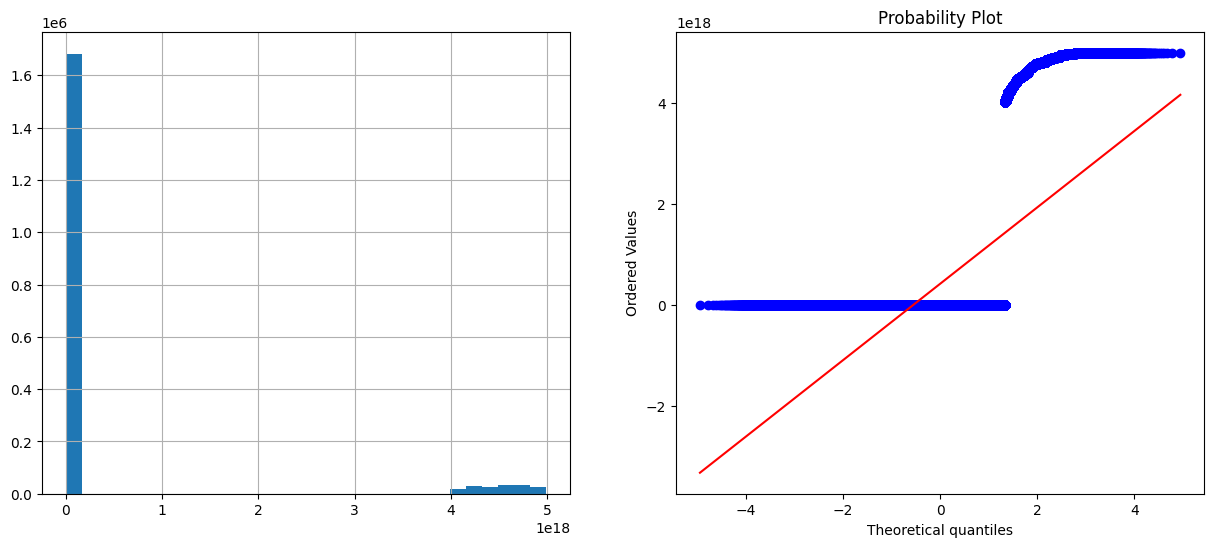

merchant


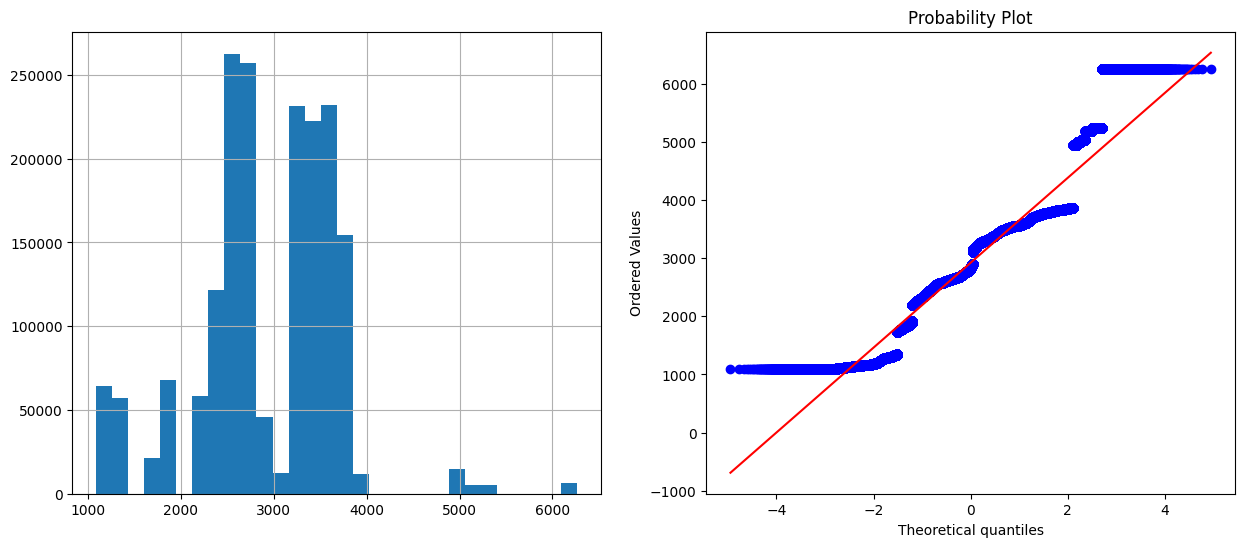

amt


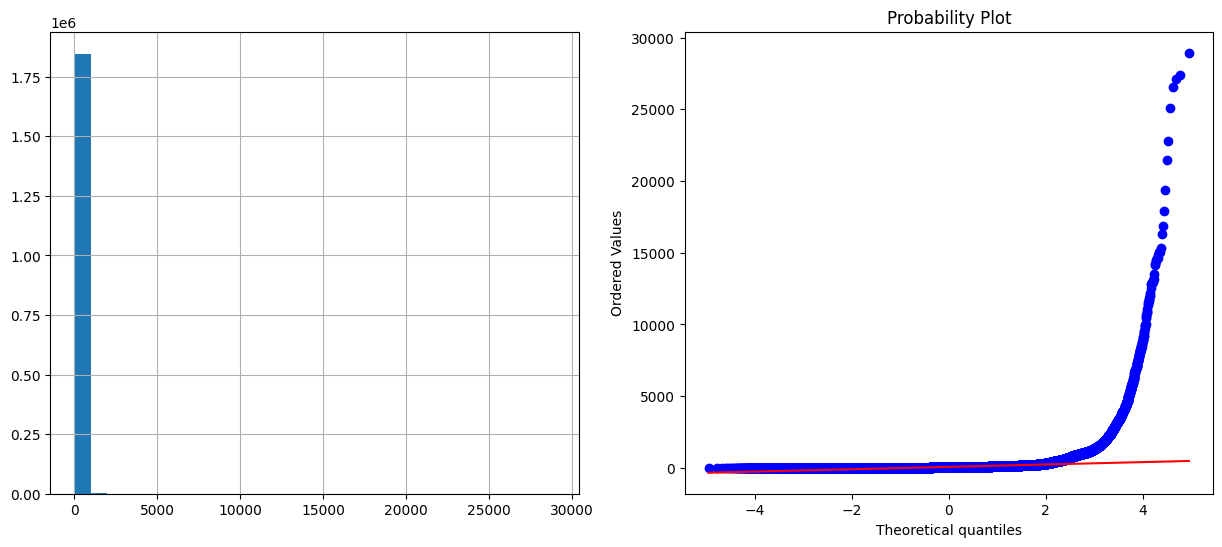

city


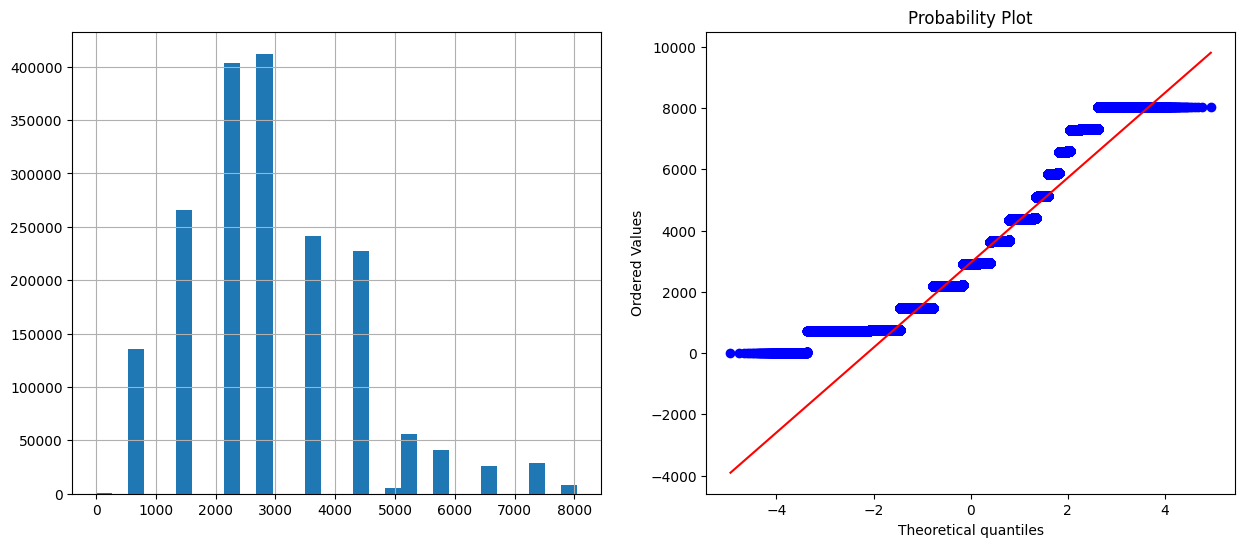

state


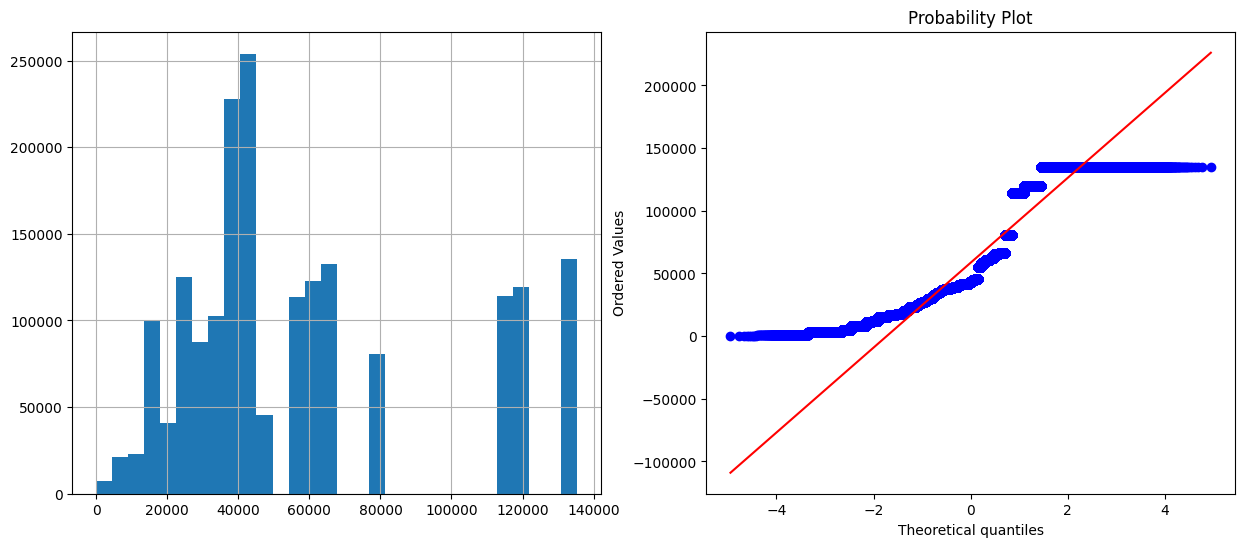

zip


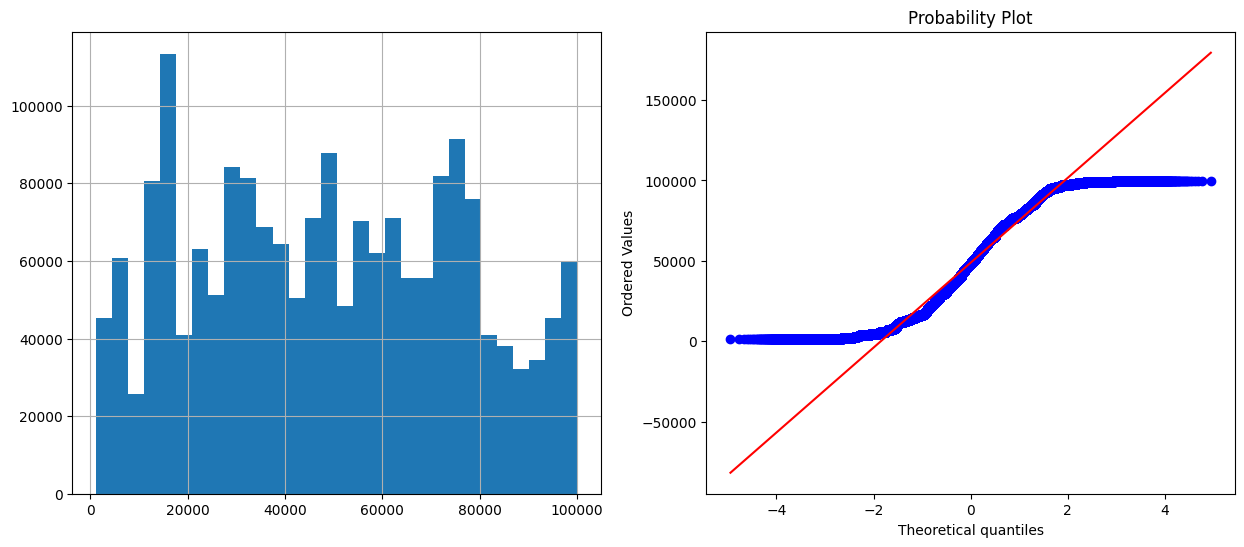

city_pop


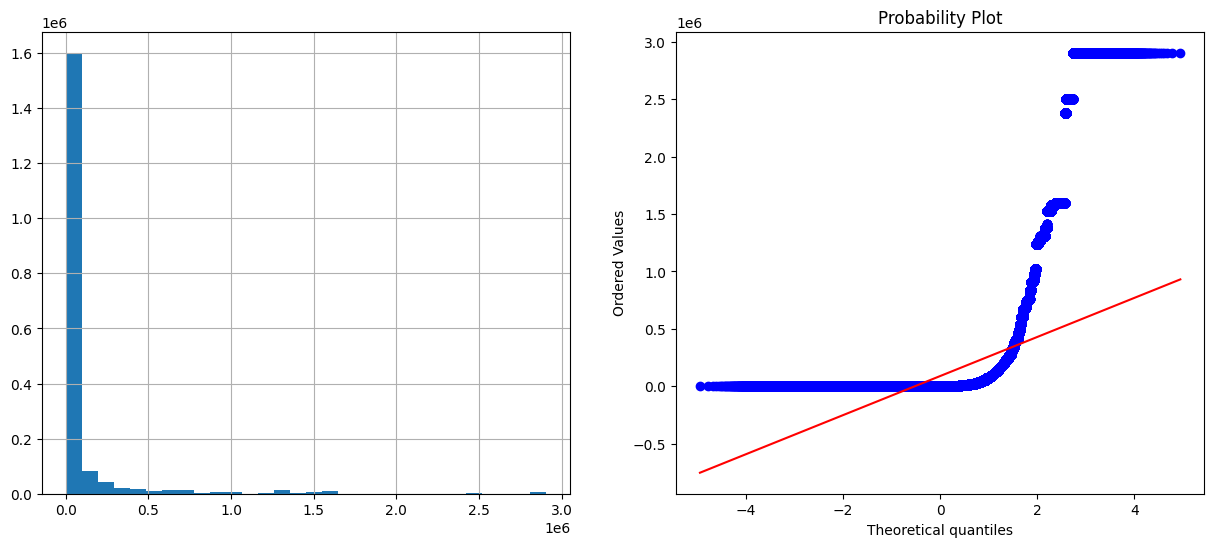

job


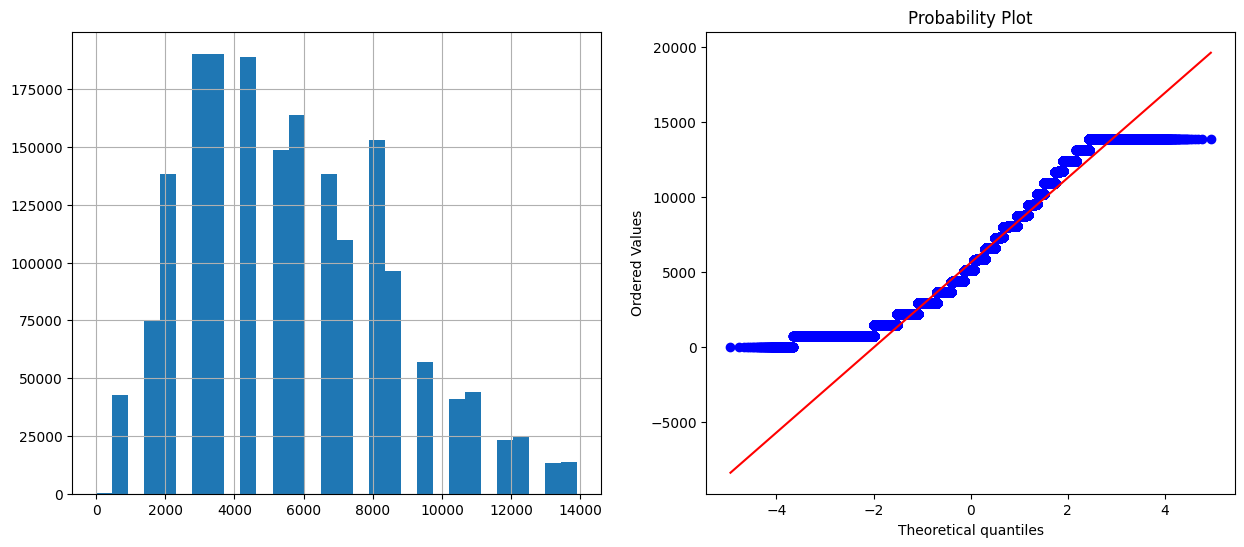

unix_time


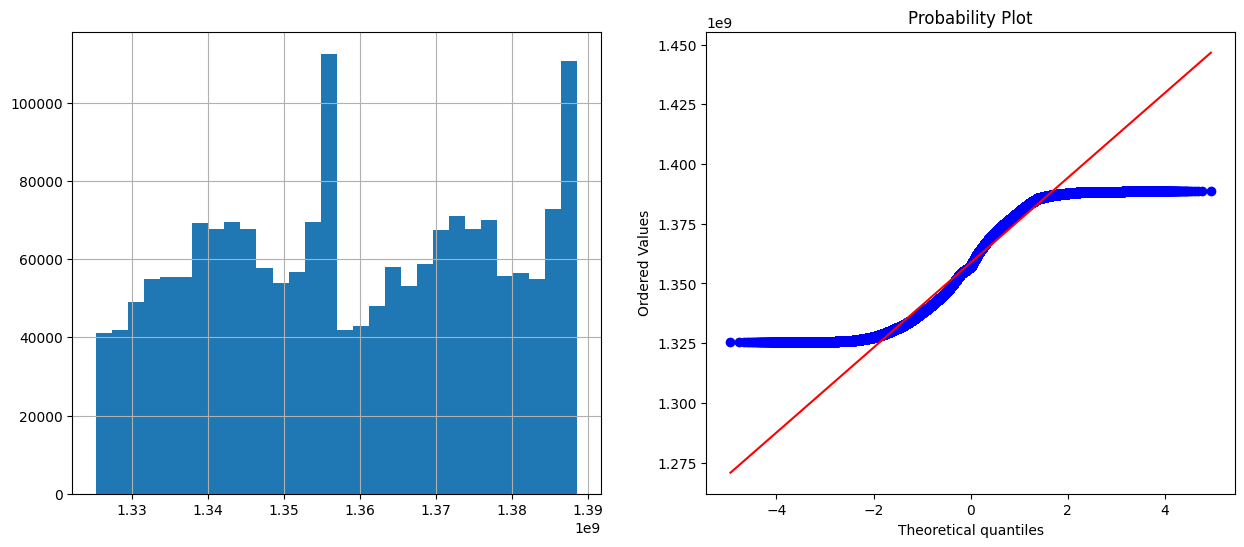

edad


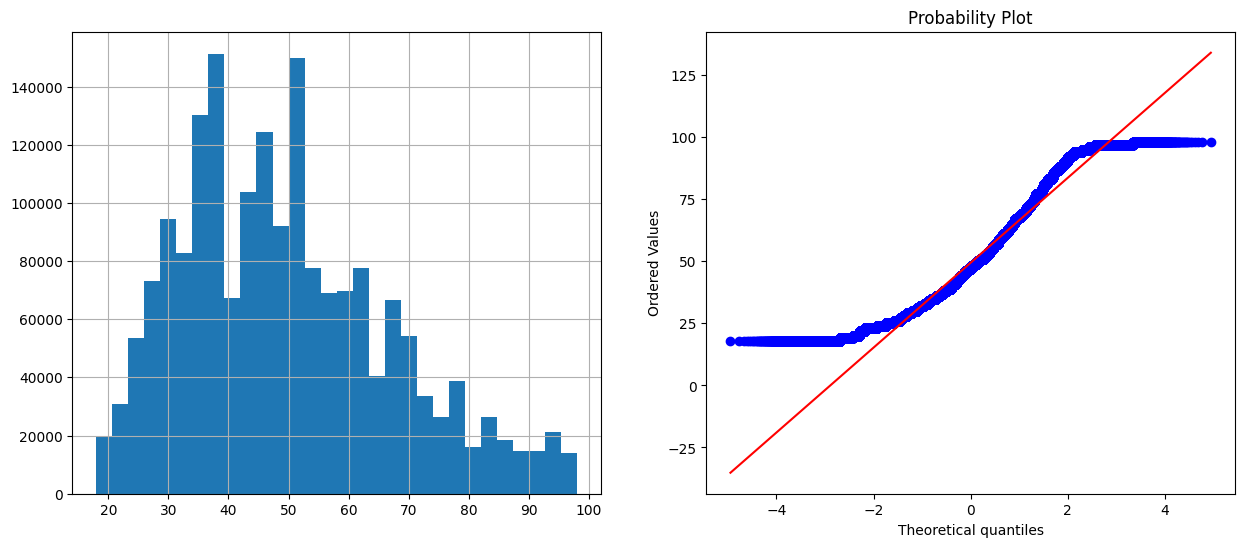

dia


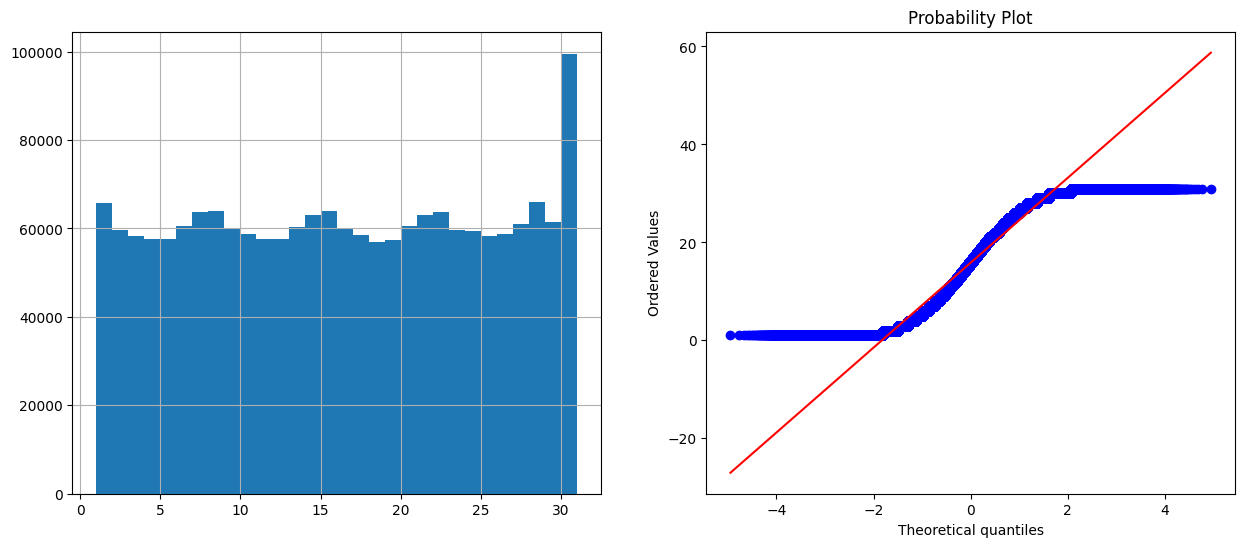

distancia_km


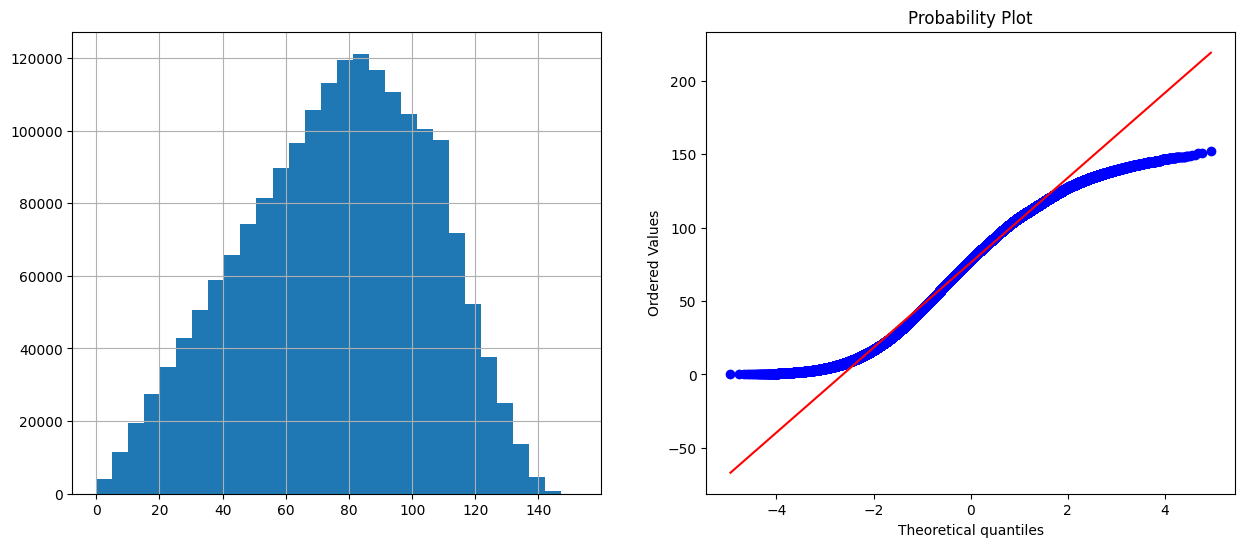

In [30]:
for var in continuas:
    print(var)
    plot_density_qq(dataset,var)

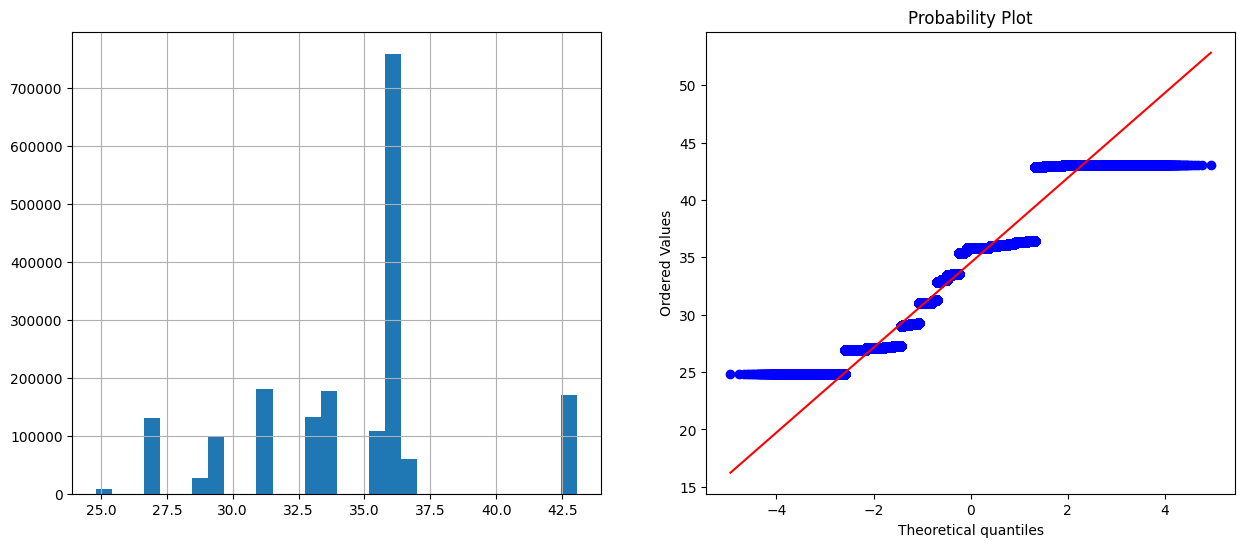

In [31]:
# Se transforma a logaritmo la variable CC Num

dataset['cc_num']=np.log(dataset['cc_num'])
plot_density_qq(dataset,'cc_num')

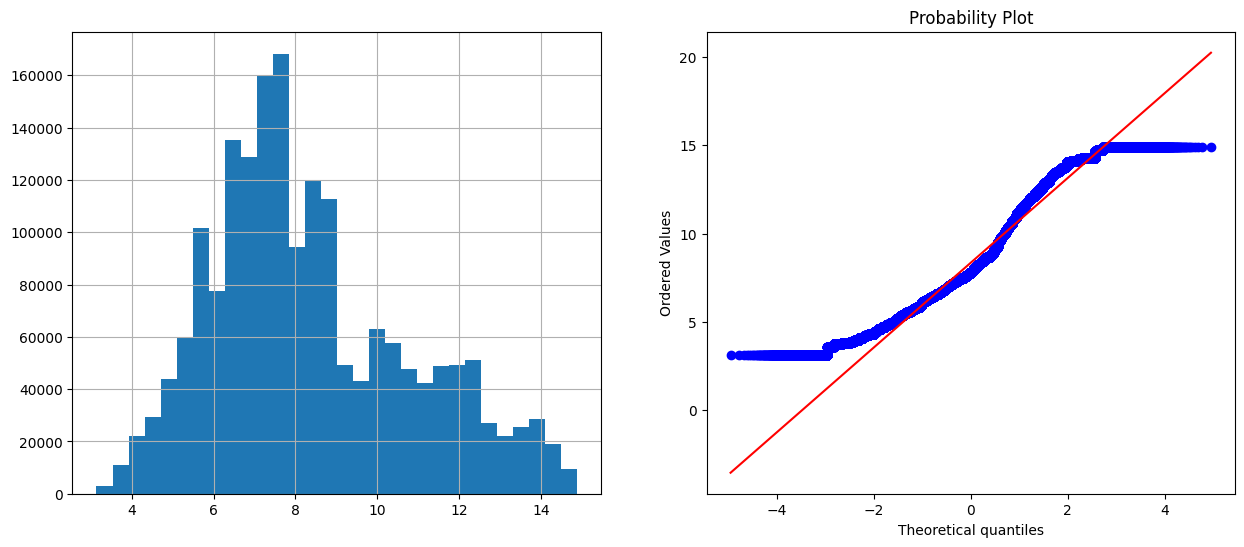

In [32]:
# Se transforma a logaritmo la variable city_pop

dataset['city_pop']=np.log(dataset['city_pop'])
plot_density_qq(dataset,'city_pop')

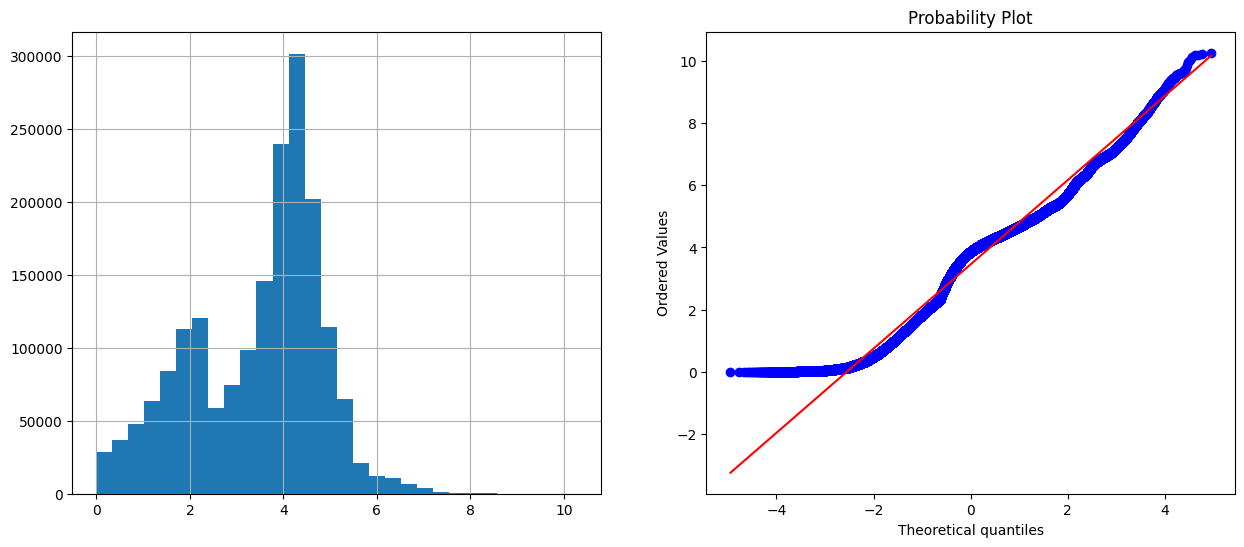

In [33]:
# Se transforma a logaritmo la variable amt

dataset['amt']=np.log(dataset['amt'])
plot_density_qq(dataset,'amt')

6. Tratamiento Outliers

In [34]:
# Capping para tratamientos de Outliers

# Encontrar IQR, LI y LS de variables continuas para hacer la sustitucion

for col in continuas:
    IQR=dataset[col].quantile(0.75)-dataset[col].quantile(0.25) #Q3 - Q1
    LI=dataset[col].quantile(0.25)-(IQR*1.75) #limite inferior
    LS=dataset[col].quantile(0.75)+(IQR*1.75)# limite superior
    if LI<0: #Evitar negativos 
        LI=0
    dataset[col]=np.where(dataset[col]>LS,LS,
                                np.where(dataset[col]<LI ,LI,dataset[col])) ##Sustituir los outliers por los limites

In [35]:
def plotDistBoxQQ(dataset,col):
    '''Descripcion:Muestra las graficas de distribucion , Boxplot y Q-QPlot para detectar Outliers
        Input: dataset -> pandas dataframe , col ->string con nombre de columna
        output: visulizacion de 3 plots
        '''
    plt.figure(figsize=(20,6)) 

    plt.subplot(1,3,1)
    sns.distplot(dataset[col],bins=30)
    plt.title("Histograma y Densidad")

    plt.subplot(1,3,2)
    sns.boxplot(y=dataset[col])
    plt.title("BoxPlot")

    plt.subplot(1,3,3)
    stats.probplot(dataset[col],dist="norm",plot=plt)
    plt.title("Q-Q Plot")

C:\Users\lgutierrez\AppData\Local\Temp\ipykernel_20192\2820577040.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col],bins=30)
C:\Users\lgutierrez\AppData\Local\Temp\ipykernel_20192\2820577040.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col],bins=30)
C:\Users\lgutier

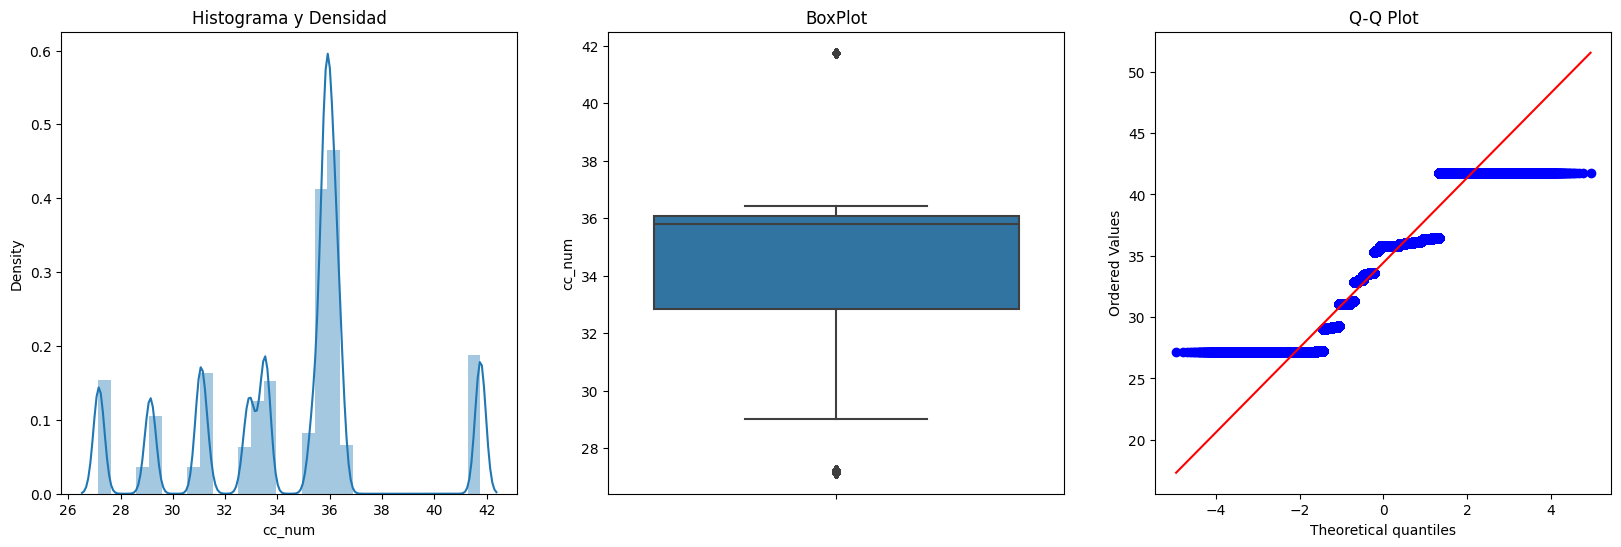

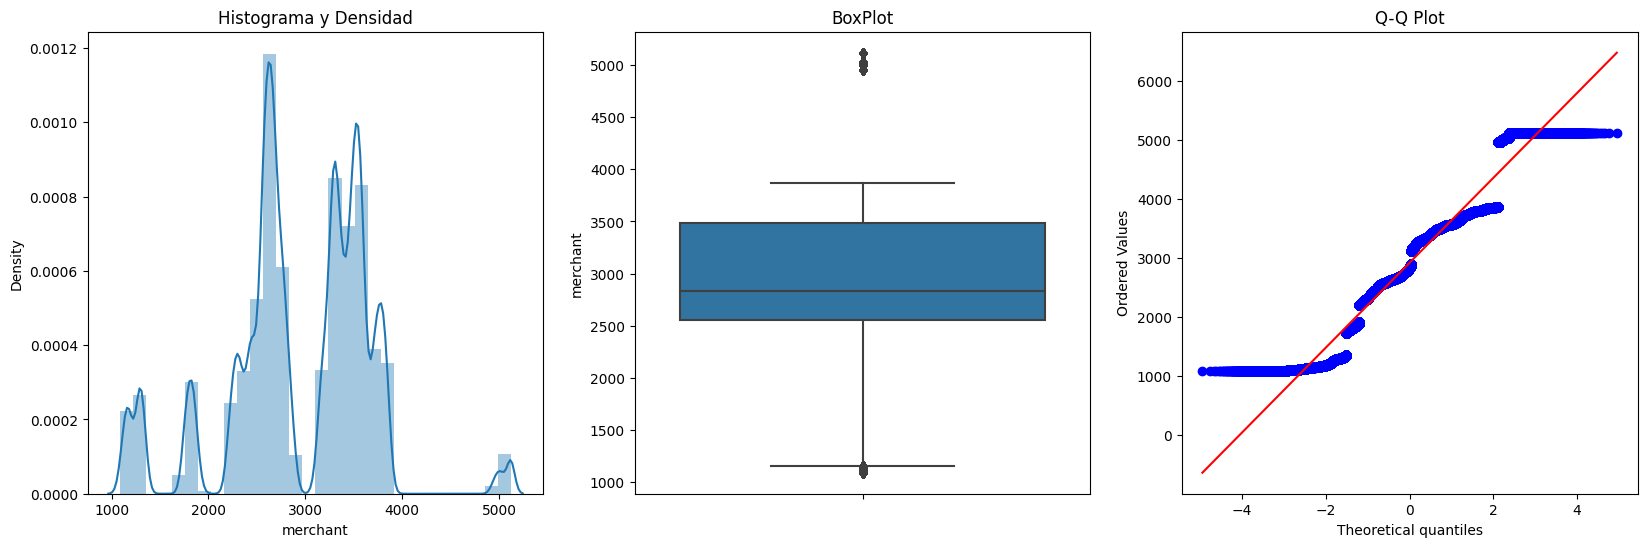

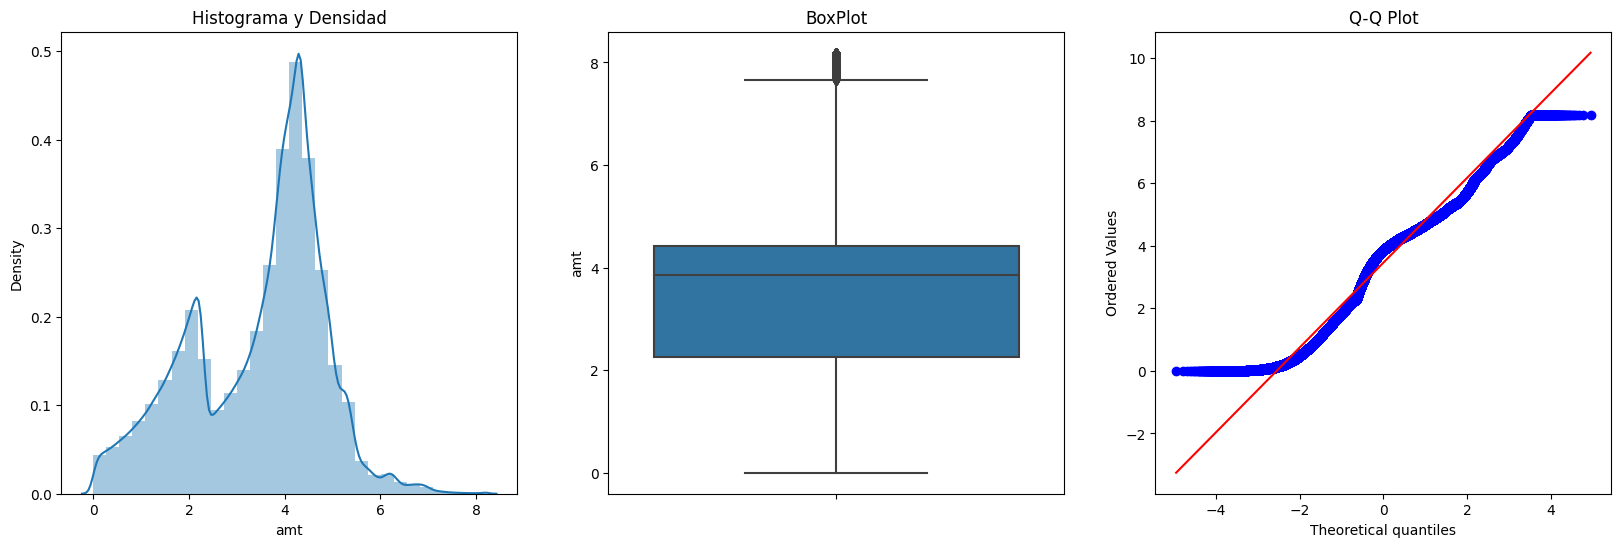

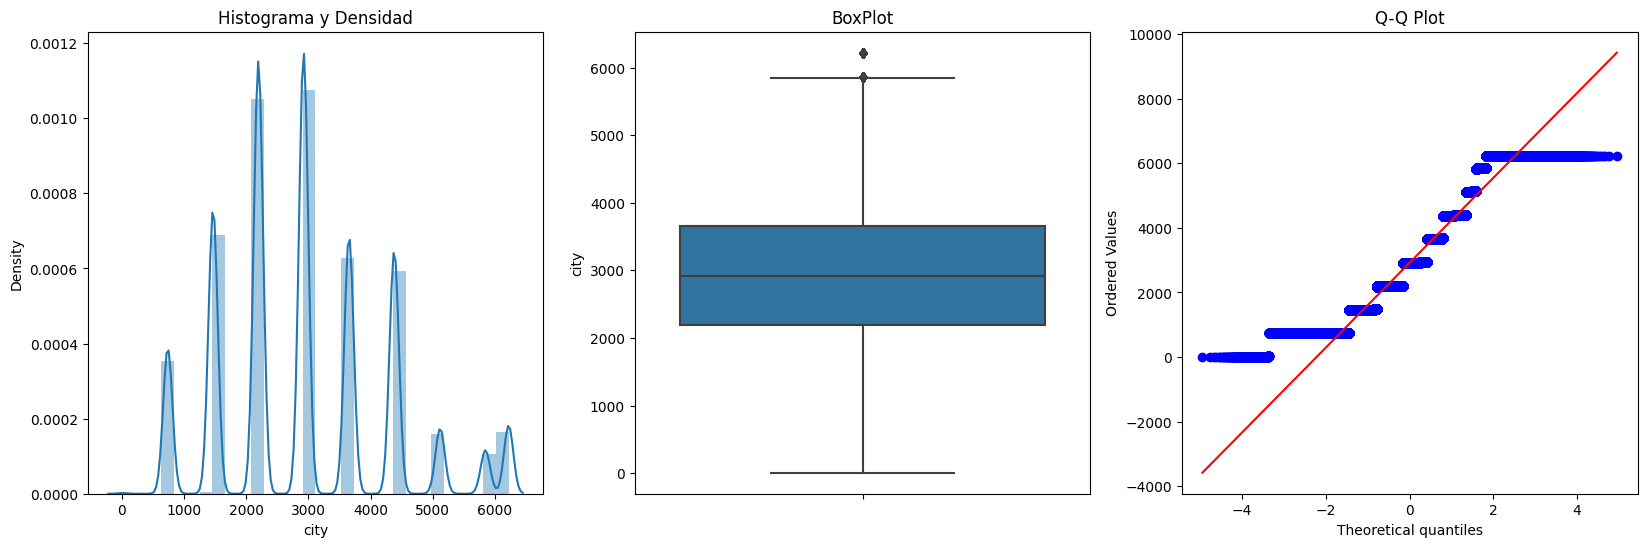

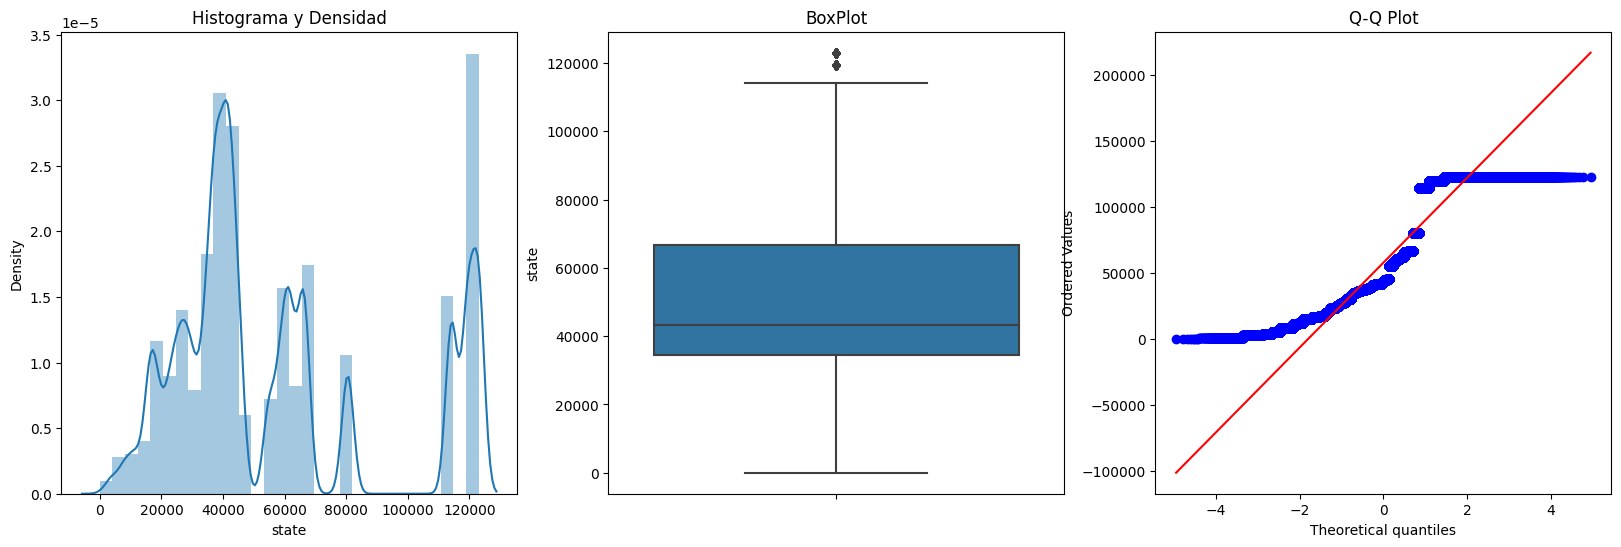

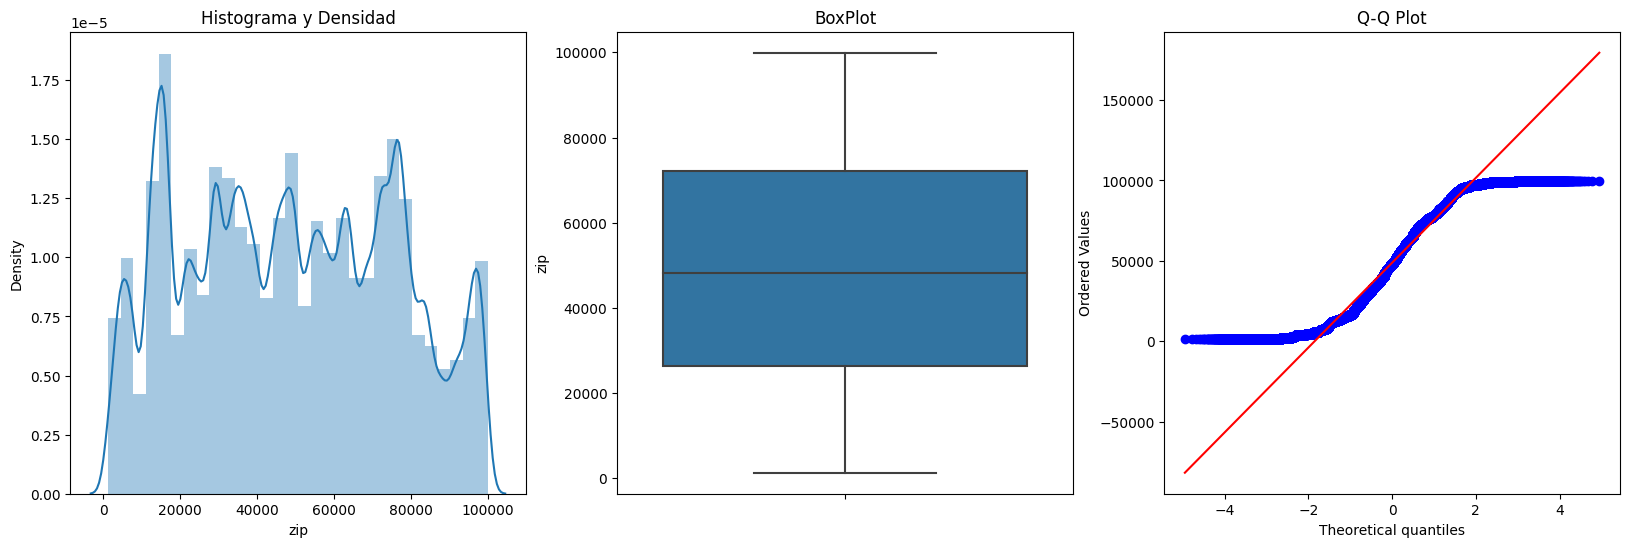

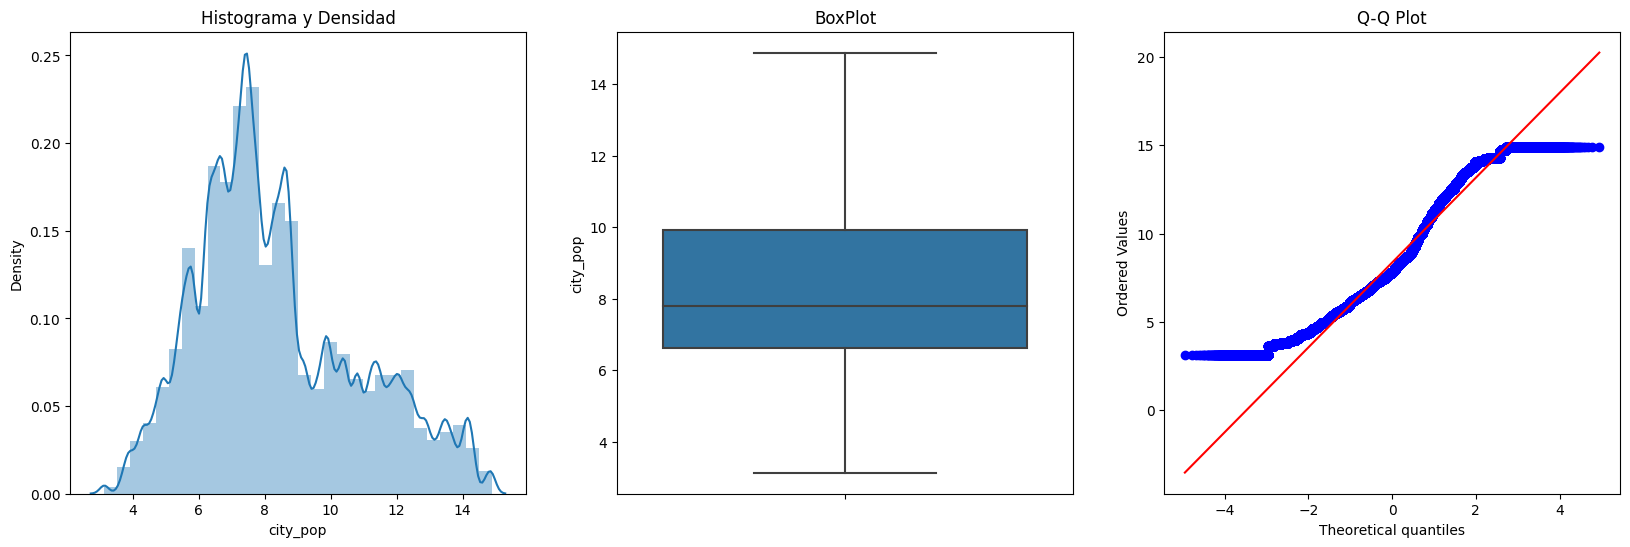

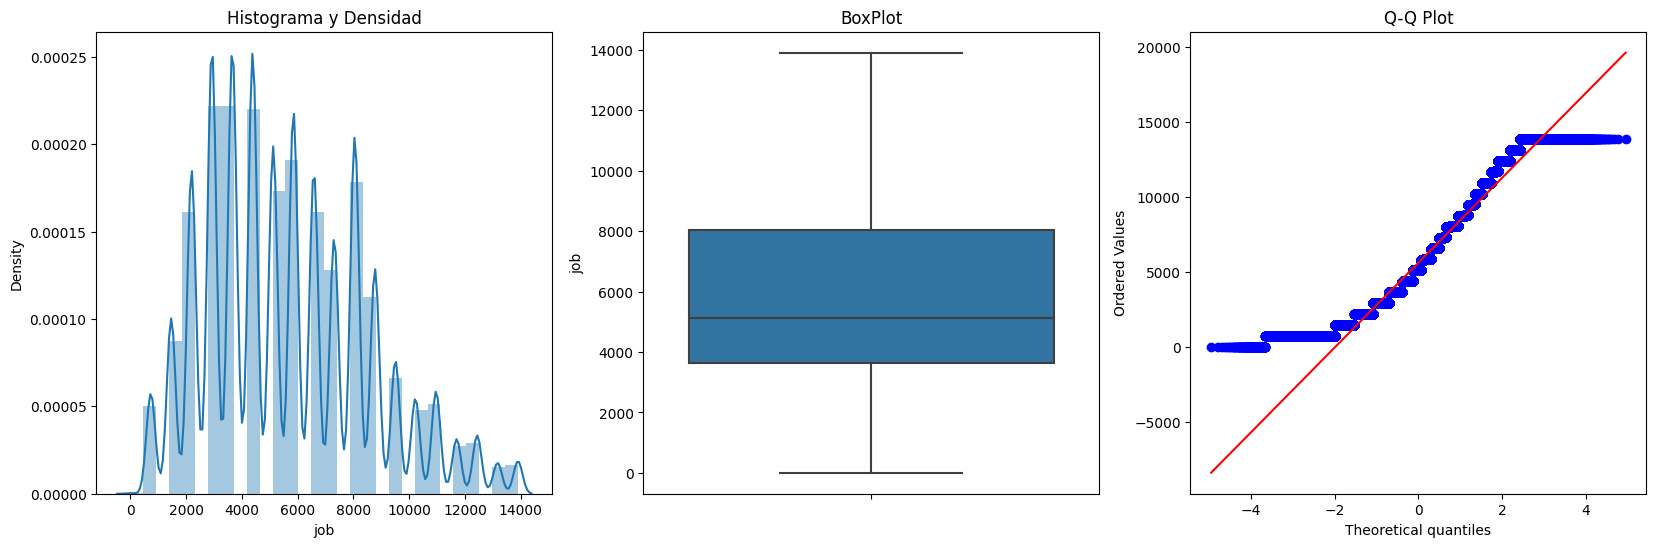

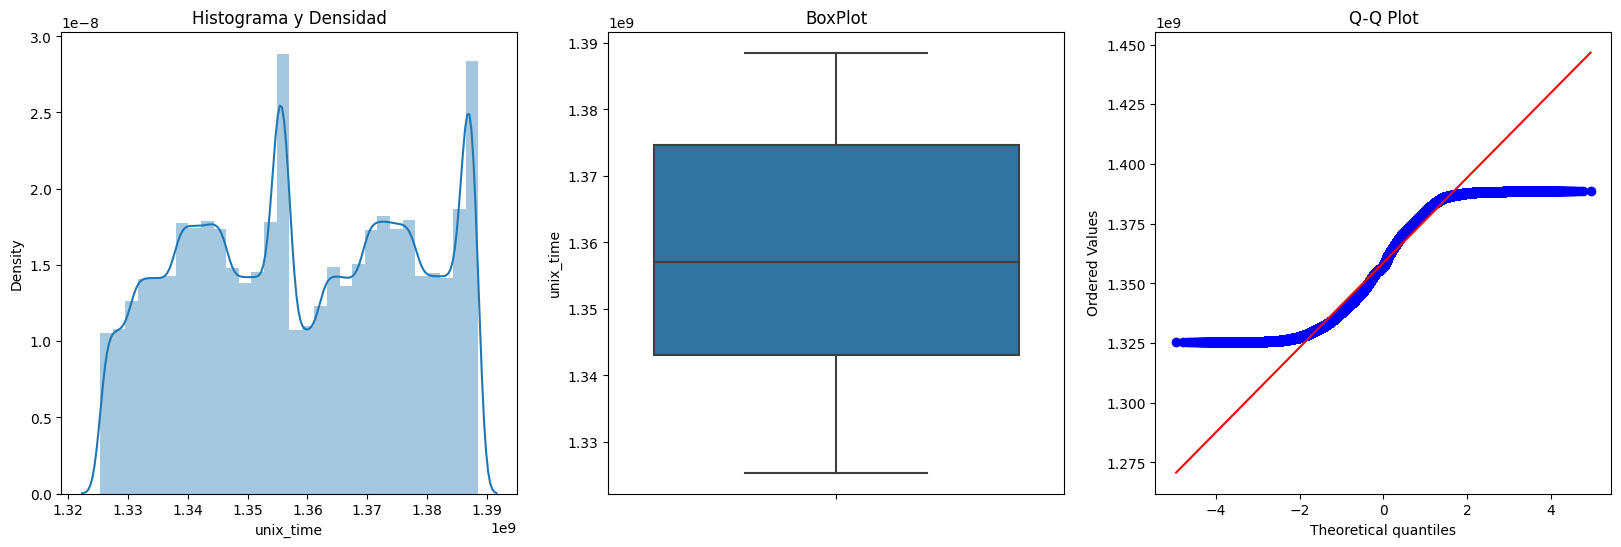

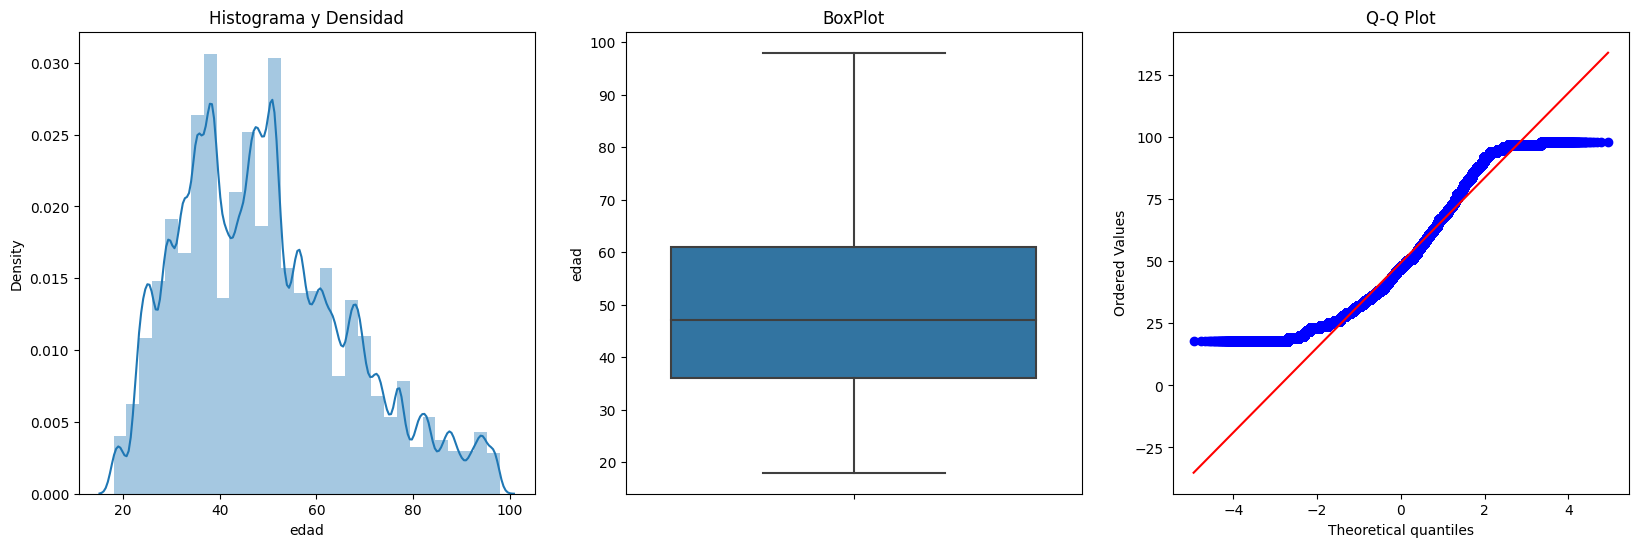

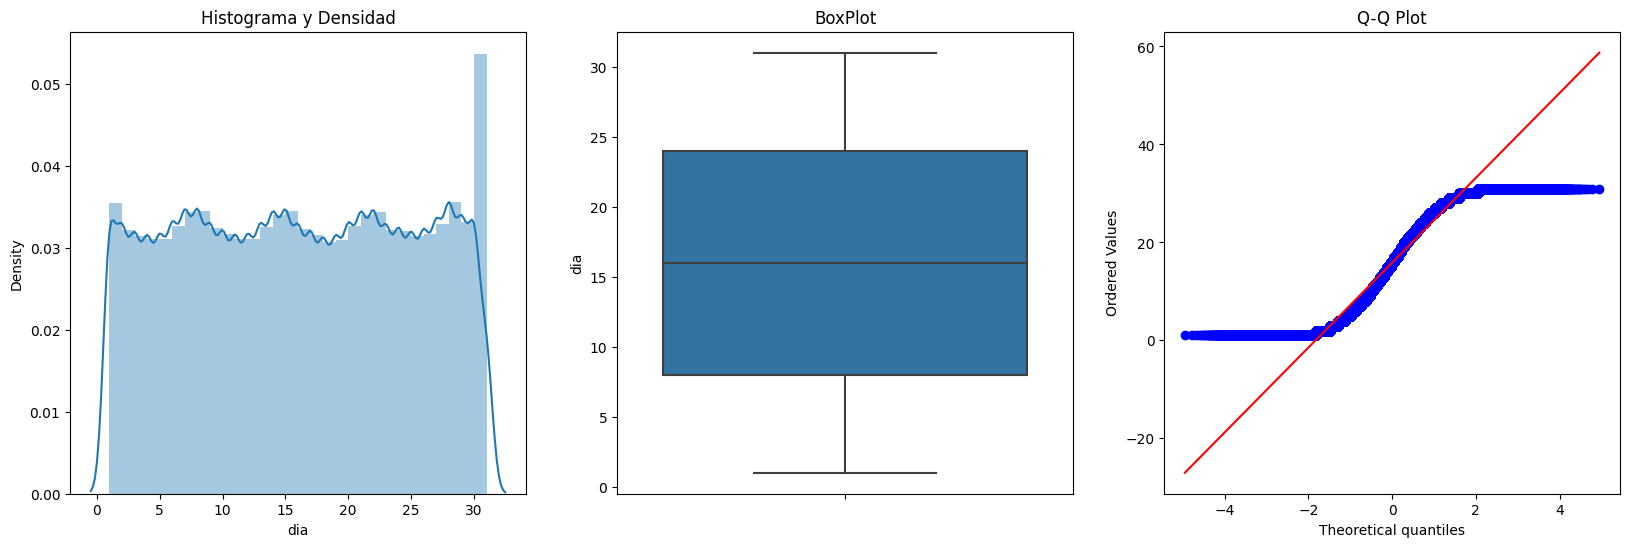

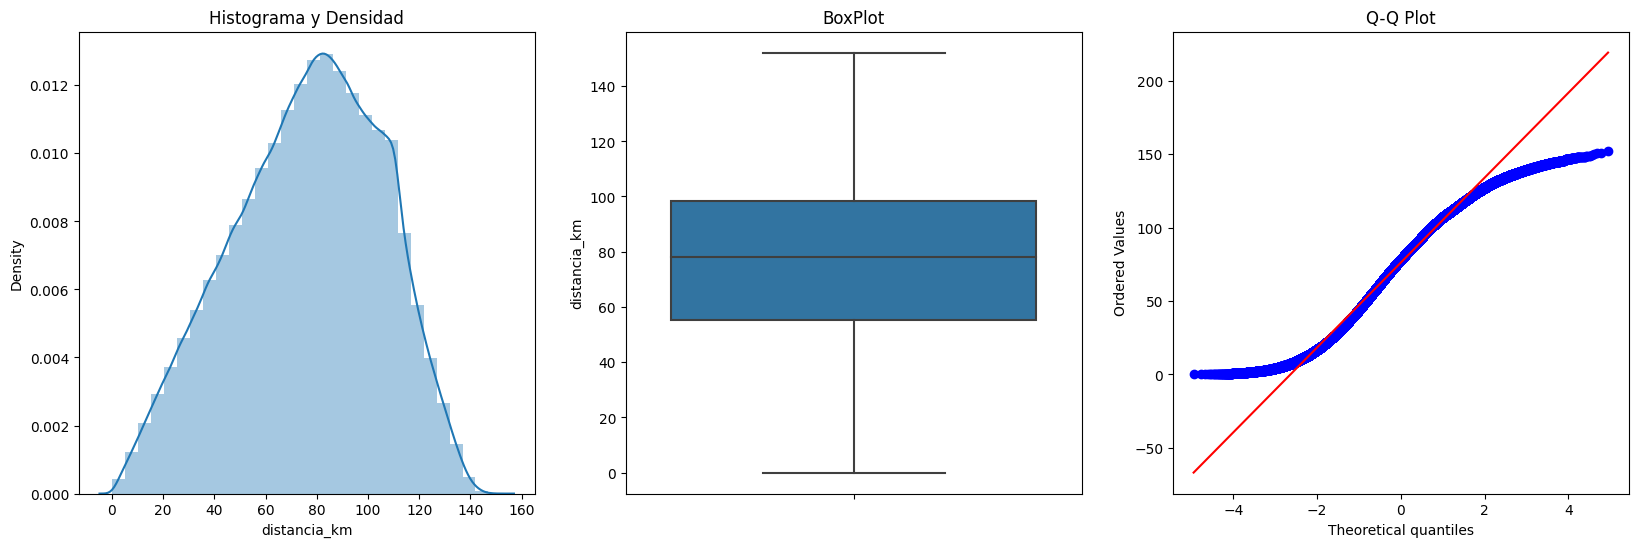

In [36]:
# Graficar para ver el cambio de Outliers
for col in continuas:
    plotDistBoxQQ(dataset,col)

7. Feature Scaling

In [37]:
## Resumen de la data
dataset.describe()

,cc_num,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,edad,año,mes,dia,distancia_km
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,3.443186e+01,2.919293e+03,1.437675e+05,3.455585e+00,4.521959e-01,2.918361e+03,5.765482e+04,4.881326e+04,8.357133e+00,5.627489e+03,1.358674e+09,5.210015e-03,4.943525e+01,2.019501e+03,7.152067e+00,1.585076e+01,7.611173e+01
std,3.647910e+00,7.388314e+02,3.423169e+04,1.386528e+00,4.977097e-01,1.350379e+03,3.458011e+04,2.688185e+04,2.452527e+00,2.881552e+03,1.819508e+07,7.199217e-02,1.741688e+01,4.999996e-01,3.424954e+00,8.876245e+00,2.911697e+01
min,2.713714e+01,1.090000e+03,5.795600e+04,0.000000e+00,0.000000e+00,6.000000e+00,9.000000e+00,1.257000e+03,3.135494e+00,7.000000e+00,1.325376e+09,0.000000e+00,1.800000e+01,2.019000e+03,1.000000e+00,1.000000e+00,2.225452e-02
25%,3.282422e+01,2.556000e+03,1.300850e+05,2.265921e+00,0.000000e+00,2.190000e+03,3.442500e+04,2.623700e+04,6.608001e+00,3.647000e+03,1.343017e+09,0.000000e+00,3.600000e+01,2.019000e+03,4.000000e+00,8.000000e+00,5.532009e+01
50%,3.579764e+01,2.833000e+03,1.393220e+05,3.859677e+00,0.000000e+00,2.920000e+03,4.313400e+04,4.817400e+04,7.800982e+00,5.127000e+03,1.357089e+09,0.000000e+00,4.700000e+01,2.020000e+03,7.000000e+00,1.600000e+01,7.821638e+01
75%,3.607398e+01,3.488000e+03,1.754600e+05,4.420045e+00,1.000000e+00,3.655000e+03,6.662700e+04,7.204200e+04,9.919755e+00,8.021000e+03,1.374581e+09,0.000000e+00,6.100000e+01,2.020000e+03,1.000000e+01,2.400000e+01,9.850947e+01
max,4.176106e+01,5.119000e+03,1.880290e+05,8.189761e+00,1.000000e+00,6.218750e+03,1.229805e+05,9.992100e+04,1.488253e+01,1.389800e+04,1.388534e+09,1.000000e+00,9.800000e+01,2.020000e+03,1.200000e+01,3.100000e+01,1.521172e+02


In [38]:
# Aplicar Scaler
scaler=StandardScaler()
scaler.fit(dataset) 


data_scaled=scaler.transform(dataset)
data_scaled=pd.DataFrame(data_scaled,columns=dataset.columns)

In [39]:
## Resumen de la data con scaler
round(data_scaled.describe(),2) 

,cc_num,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,edad,año,mes,dia,distancia_km
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.0,1852394.00,1852394.00,1852394.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.0,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
min,-2.00,-2.48,-2.51,-2.49,-0.91,-2.16,-1.67,-1.77,-2.13,-1.95,-1.83,-0.07,-1.80,-1.0,-1.80,-1.67,-2.61
25%,-0.44,-0.49,-0.40,-0.86,-0.91,-0.54,-0.67,-0.84,-0.71,-0.69,-0.86,-0.07,-0.77,-1.0,-0.92,-0.88,-0.71
50%,0.37,-0.12,-0.13,0.29,-0.91,0.00,-0.42,-0.02,-0.23,-0.17,-0.09,-0.07,-0.14,1.0,-0.04,0.02,0.07
75%,0.45,0.77,0.93,0.70,1.10,0.55,0.26,0.86,0.64,0.83,0.87,-0.07,0.66,1.0,0.83,0.92,0.77
max,2.01,2.98,1.29,3.41,1.10,2.44,1.89,1.90,2.66,2.87,1.64,13.82,2.79,1.0,1.42,1.71,2.61


In [40]:
# Aplicar MinMaxScaler
# Normalizar las variables continuas

mm_scaler=MinMaxScaler()
mm_scaler.fit(dataset) 


data_mmscaled=mm_scaler.transform(dataset)
data_mmscaled=pd.DataFrame(data_mmscaled,columns=dataset.columns)

In [41]:
## Resumen de la data con scaler
round(data_mmscaled.describe(),2) 

,cc_num,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,edad,año,mes,dia,distancia_km
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.0,1852394.00,1852394.00,1852394.00
mean,0.50,0.45,0.66,0.42,0.45,0.47,0.47,0.48,0.44,0.40,0.53,0.01,0.39,0.5,0.56,0.50,0.50
std,0.25,0.18,0.26,0.17,0.50,0.22,0.28,0.27,0.21,0.21,0.29,0.07,0.22,0.5,0.31,0.30,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,0.39,0.36,0.55,0.28,0.00,0.35,0.28,0.25,0.30,0.26,0.28,0.00,0.22,0.0,0.27,0.23,0.36
50%,0.59,0.43,0.63,0.47,0.00,0.47,0.35,0.48,0.40,0.37,0.50,0.00,0.36,1.0,0.55,0.50,0.51
75%,0.61,0.60,0.90,0.54,1.00,0.59,0.54,0.72,0.58,0.58,0.78,0.00,0.54,1.0,0.82,0.77,0.65
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


In [42]:
# Aplicar MinMaxScaler para no tener negativos
dataset=data_mmscaled

In [43]:
# Convertir la variable dependiente a entero sin decimal
dataset['is_fraud'] = dataset['is_fraud'].astype(int)

### Modelado

1. Balanceo de datos

In [44]:
# Obtener como esta la cantidad de fraude y no fraude
dataset['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [45]:
# Balancear con el doble de fraude

no_fraud=dataset[dataset['is_fraud'] == 0]
fraud=dataset[dataset['is_fraud'] == 1]

no_fraud = no_fraud.sample(2*fraud.shape[0], random_state=2023)

no_fraud.shape, fraud.shape


((19302, 17), (9651, 17))

In [46]:
# Data final con el concatenado de no_fraud y fraud
dataset = pd.concat([no_fraud, fraud])
dataset.head()

,cc_num,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,edad,año,mes,dia,distancia_km
253880,0.266451,0.371308,0.554527,0.615907,0.0,0.586536,0.494147,0.331529,0.781904,0.682960,0.173120,0,0.2500,0.0,0.363636,0.166667,0.457245
1542192,0.000000,0.015388,0.000000,0.145412,1.0,0.822985,0.303574,0.301488,0.134758,0.316536,0.857484,0,0.5000,1.0,0.727273,0.566667,0.445449
1404072,0.438607,0.044924,0.053216,0.624362,0.0,0.703875,0.535213,0.478199,0.486178,0.368224,0.785902,0,0.2500,1.0,0.545455,0.900000,0.579455
934288,0.634193,0.053860,0.053216,0.377981,0.0,0.470484,1.000000,0.754541,0.744289,0.210352,0.508197,0,0.2625,1.0,0.000000,0.166667,0.455004
556485,0.615523,0.413999,0.625541,0.052722,0.0,0.468070,0.505833,0.624331,0.225184,0.209272,0.325129,0,0.3625,0.0,0.636364,0.800000,0.617311


2. Dividir el dataset en variables independientes y dependientes

In [47]:
# Dividir las columnas del dataset en variables independientes (X) y dependientes (Y)
x = dataset.loc[:, dataset.columns != 'is_fraud'].values
y= dataset.loc[:, 'is_fraud'].values

In [48]:
# Convertir la 'Y' en variables dummy (One hot encoding)
y_dummy=tf.keras.utils.to_categorical(y)

3. Dividr el dataset en entrenamiento y prueba

In [49]:
X_train,X_test,y_train, y_test=train_test_split(x,y_dummy,test_size=0.2,random_state=2023)

4. Crear la red neuronal

In [50]:
# Inicializar con la clase sequiential
model= kr.models.Sequential()
# Capa densa con 8 neuronas, funcion activacion ReLu y filas de datos con 16 variables
model.add(kr.layers.Dense(8,input_dim=16,activation='relu'))
# Capa salida, con 2 neuronas por las clases/categorias del dataset
model.add(kr.layers.Dense(2,activation='softmax'))

In [51]:
# Compilacion del modelo
# Función perdida, optimizador y métrica de evaluación
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [52]:
# Ajuste del modelo
# Entrenamiento del modelo

model.fit(X_train,y_train, epochs=100,batch_size=10)

Epoch 1/100
2317/2317 [==============================] - 7s 2ms/step - loss: 0.5168 - accuracy: 0.7688
Epoch 2/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4425 - accuracy: 0.8422
Epoch 3/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4319 - accuracy: 0.8536
Epoch 4/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4115 - accuracy: 0.8640
Epoch 5/100
2317/2317 [==============================] - 4s 2ms/step - loss: 0.3831 - accuracy: 0.8751
Epoch 6/100
2317/2317 [==============================] - 4s 2ms/step - loss: 0.3604 - accuracy: 0.8815
Epoch 7/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.3446 - accuracy: 0.8871
Epoch 8/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.3328 - accuracy: 0.8926
Epoch 9/100
2317/2317 [==============================] - 5s 2ms/step - loss: 0.3242 - accuracy: 0.8965
Epoch 10/100
2317/2317 [==============================] - 5s 2ms/step - l

### Evaluación 

In [53]:
# Imprimimos la precision del modelo

loss, accuracy = model.evaluate(X_test,y_test)
print(f'{loss=},{accuracy=}')

181/181 [==============================] - 0s 767us/step - loss: 0.2219 - accuracy: 0.9294
loss=0.22185225784778595,accuracy=0.9293731451034546


### Experimentación para lograr mejorar el modelo inicial

1. Variabilidad en Capas Ocultas:

In [54]:
# Listas para almacenar los resultados
capas_ocultas = []
accuracies_1 = []
losses_1 = []
precision_1=[]
perdida_1=[]

# Variar las capas ocultas
for capa_oculta in range(1,10,1): # Variar de 1 a 10, en pasos de 1
    print(f'Numero de capas ocultas:{capa_oculta}')

    # Crear el modelo red neuronal
    model_1= kr.models.Sequential()
    # Crear capa entrada
    model_1.add(kr.layers.Dense(8,input_dim=16,activation='relu'))

    # Agregar capas ocultas 
    for i in range(capa_oculta):
        model_1.add(kr.layers.Dense(8,activation='relu')) # variacion de capas con 8 neuronas

    # Agregar capa de salida
    model_1.add(kr.layers.Dense(2,activation='softmax'))

    # Compilacion del modelo
    model_1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    # Entrenar el modelo
    history_1=model_1.fit(X_train, y_train, epochs=100, batch_size=10)
    precision_1.append(history_1.history['accuracy'])
    perdida_1.append(history_1.history['loss'])

    
    # Evaluar modelo
    loss, accuracy = model_1.evaluate(X_test,y_test)
    capas_ocultas.append(capa_oculta)
    accuracies_1.append(accuracy)
    losses_1.append(loss)

Numero de capas ocultas:1
Epoch 1/100
2317/2317 [==============================] - 2s 700us/step - loss: 0.5342 - accuracy: 0.7504
Epoch 2/100
2317/2317 [==============================] - 2s 684us/step - loss: 0.4177 - accuracy: 0.8542
Epoch 3/100
2317/2317 [==============================] - 2s 753us/step - loss: 0.3779 - accuracy: 0.8710
Epoch 4/100
2317/2317 [==============================] - 2s 812us/step - loss: 0.3448 - accuracy: 0.8835
Epoch 5/100
2317/2317 [==============================] - 2s 795us/step - loss: 0.3224 - accuracy: 0.8936
Epoch 6/100
2317/2317 [==============================] - 2s 792us/step - loss: 0.3077 - accuracy: 0.9002
Epoch 7/100
2317/2317 [==============================] - 2s 907us/step - loss: 0.2972 - accuracy: 0.9048
Epoch 8/100
2317/2317 [==============================] - 2s 777us/step - loss: 0.2887 - accuracy: 0.9064
Epoch 9/100
2317/2317 [==============================] - 2s 770us/step - loss: 0.2829 - accuracy: 0.9090
Epoch 10/100
2317/2317 [=====

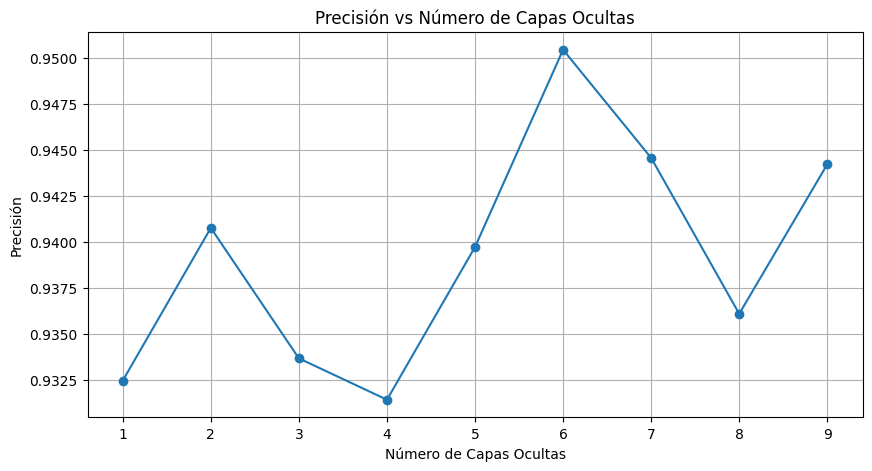

In [81]:
# Crear el gráfico de Precisión vs Número de capas ocultas
plt.figure(figsize=(10, 5))
plt.plot(capas_ocultas, accuracies_1, marker='o')
plt.title('Precisión vs Número de Capas Ocultas')
plt.xlabel('Número de Capas Ocultas')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

###### Numero de neuronas con mayor accuracy: 6

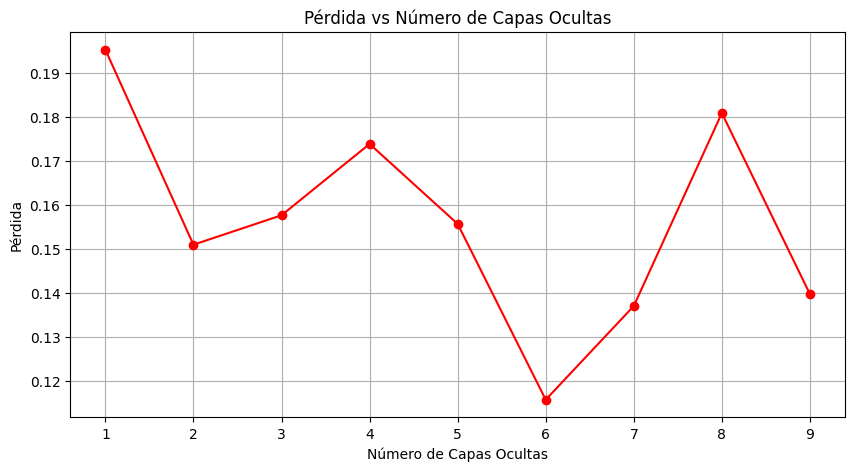

In [82]:
# Crear el gráfico de Pérdida vs Número de capas ocultas
plt.figure(figsize=(10, 5))
plt.plot(capas_ocultas, losses_1, marker='o', color='r')
plt.title('Pérdida vs Número de Capas Ocultas')
plt.xlabel('Número de Capas Ocultas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.show()

###### Numrero de capas ocultas con mejor perdida: 6

2. Variabilidad de neuronas

In [84]:
# Listas para almacenar los resultados
numero_neuronas = []
accuracies_2 = []
losses_2 = []
precision_2=[]
perdida_2=[]

# Definir el incremento logaritmico
array = np.logspace(np.log10(10), np.log10(1000), num=10, base=10, dtype=int)

# Variar el numero de neuronas
for num_neuronas in array:

    print(f'Numero de neuronas por capas:{num_neuronas}')

    # Crear el modelo red neuronal
    model_2= kr.models.Sequential()
    # Crear capa entrada
    model_2.add(kr.layers.Dense(num_neuronas,input_dim=16,activation='relu')) # variacion de neuronas
    # Agregar capa de salida
    model_2.add(kr.layers.Dense(2,activation='softmax'))

    # Compilacion del modelo
    model_2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    # Entrenar el modelo
    history_2=model_2.fit(X_train, y_train, epochs=100, batch_size=10)
    precision_2.append(history_2.history['accuracy'])
    perdida_2.append(history_2.history['loss'])
    
    # Evaluar modelo
    loss, accuracy = model_2.evaluate(X_test,y_test)
    numero_neuronas.append(num_neuronas)
    accuracies_2.append(accuracy)
    losses_2.append(loss)

Numero de neuronas por capas:10
Epoch 1/100
2317/2317 [==============================] - 4s 2ms/step - loss: 0.4955 - accuracy: 0.7914
Epoch 2/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.4373 - accuracy: 0.8473
Epoch 3/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.4210 - accuracy: 0.8578
Epoch 4/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3940 - accuracy: 0.8697
Epoch 5/100
2317/2317 [==============================] - 4s 2ms/step - loss: 0.3701 - accuracy: 0.8783
Epoch 6/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3537 - accuracy: 0.8833
Epoch 7/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3415 - accuracy: 0.8876
Epoch 8/100
2317/2317 [==============================] - 3s 2ms/step - loss: 0.3330 - accuracy: 0.8902
Epoch 9/100
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3250 - accuracy: 0.8927
Epoch 10/100
2317/2317 [=================

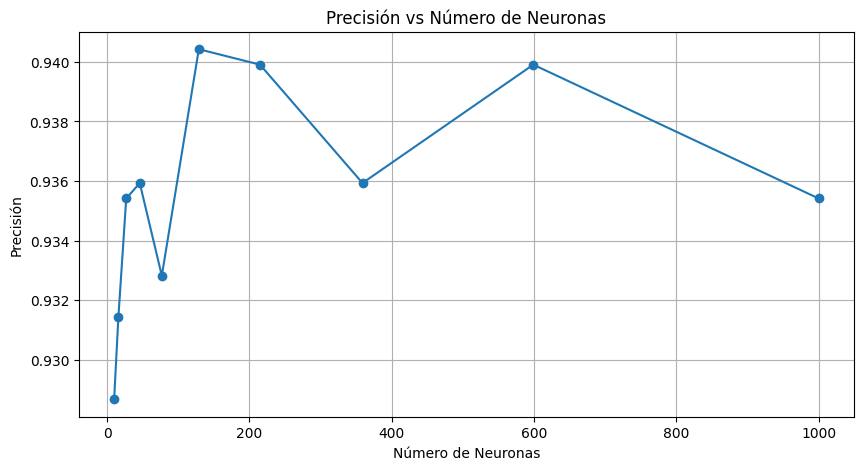

In [85]:
# Crear el gráfico de Precisión vs Número de neuronas
plt.figure(figsize=(10, 5))
plt.plot(numero_neuronas, accuracies_2, marker='o')
plt.title('Precisión vs Número de Neuronas')
plt.xlabel('Número de Neuronas')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

###### Numero de neuronas con mayor accuracy: 129

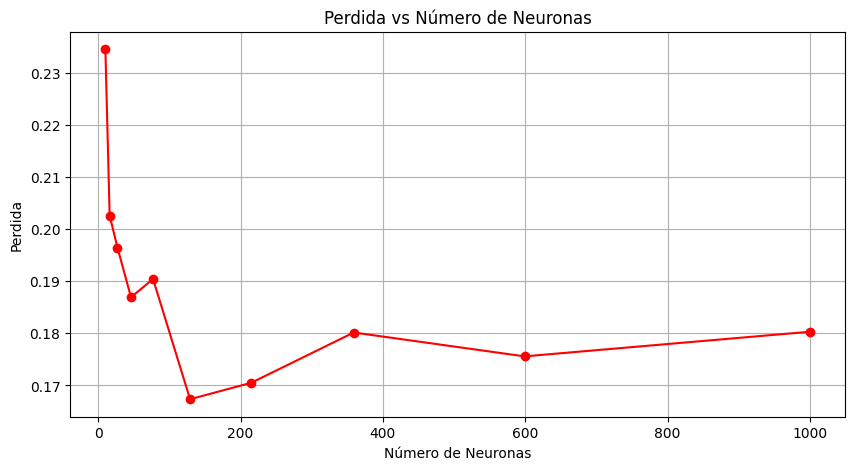

In [86]:
# Crear el gráfico de Perdida vs Número de neuronas
plt.figure(figsize=(10, 5))
plt.plot(numero_neuronas, losses_2, marker='o',color='r')
plt.title('Perdida vs Número de Neuronas')
plt.xlabel('Número de Neuronas')
plt.ylabel('Perdida')
plt.grid(True)
plt.show()

###### Numero de neuronas con menor perdida: 129

3. Variabilidad de Epocas

In [88]:
# Listas para almacenar los resultados
numero_epocas = []
accuracies_3 = []
losses_3 = []
precision_3= []
perdida_3= []

# Definir el incremiento logaritmico
array = [10,47,80,150,200,500]
# array = np.logspace(np.log10(10), np.log10(5000), num=5, base=10, dtype=int), # Se tardó mas de 10 horas

# Variar el numero de epocas
for num_epocas in array:

    print(f'Numero de epocas en la red neuronal:{num_epocas}')

    # Crear el modelo red neuronal
    model_3= kr.models.Sequential()
    # Crear capa entrada
    model_3.add(kr.layers.Dense(8,input_dim=16,activation='relu'))
    # Agregar capa de salida
    model_3.add(kr.layers.Dense(2,activation='softmax'))

    # Compilacion del modelo
    model_3.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    # Entrenar el modelo
    history_3=model_3.fit(X_train, y_train, epochs=num_epocas, batch_size=10) # variacion de epocas
    precision_3.append(history_3.history['accuracy'])
    perdida_3.append(history_3.history['loss'])
    
    # Evaluar modelo
    loss, accuracy = model_3.evaluate(X_test,y_test)
    numero_epocas.append(num_epocas)
    accuracies_3.append(accuracy)
    losses_3.append(loss)

Numero de epocas en la red neuronal:10
Epoch 1/10
2317/2317 [==============================] - 7s 3ms/step - loss: 0.5319 - accuracy: 0.7555
Epoch 2/10
2317/2317 [==============================] - 6s 3ms/step - loss: 0.4344 - accuracy: 0.8466
Epoch 3/10
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4079 - accuracy: 0.8581
Epoch 4/10
2317/2317 [==============================] - 4s 2ms/step - loss: 0.3747 - accuracy: 0.8718
Epoch 5/10
2317/2317 [==============================] - 3s 2ms/step - loss: 0.3506 - accuracy: 0.8815
Epoch 6/10
2317/2317 [==============================] - 3s 2ms/step - loss: 0.3357 - accuracy: 0.8882
Epoch 7/10
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3253 - accuracy: 0.8929
Epoch 8/10
2317/2317 [==============================] - 3s 1ms/step - loss: 0.3178 - accuracy: 0.8968
Epoch 9/10
2317/2317 [==============================] - 3s 2ms/step - loss: 0.3109 - accuracy: 0.8997
Epoch 10/10
181/181 [======================

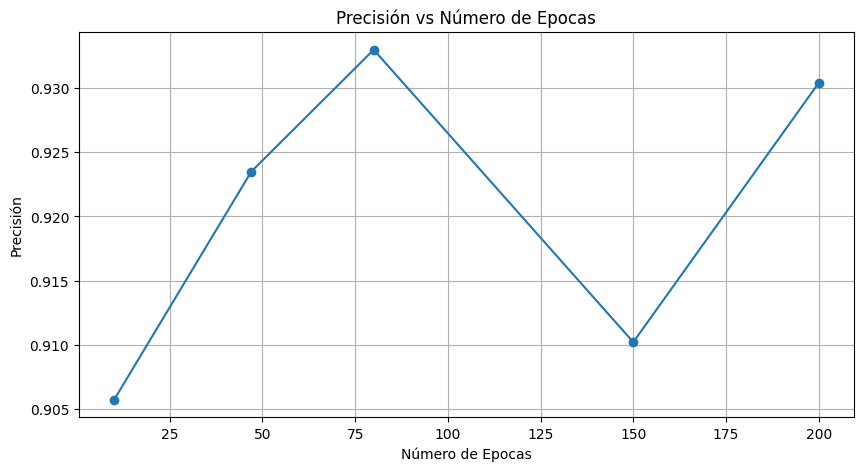

In [89]:
# Crear el gráfico de Precisión vs Número de epocas
plt.figure(figsize=(10, 5))
plt.plot(numero_epocas, accuracies_3, marker='o')
plt.title('Precisión vs Número de Epocas')
plt.xlabel('Número de Epocas')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

###### Numero de epocas con mejor accuracy: 80

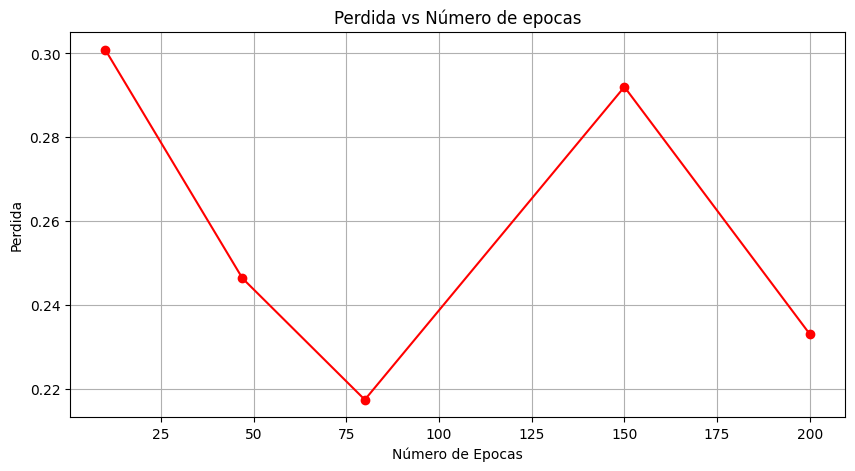

In [90]:
# Crear el gráfico de Perdida vs Número de epocas
plt.figure(figsize=(10, 5))
plt.plot(numero_epocas, losses_3, marker='o',color='r')
plt.title('Perdida vs Número de epocas')
plt.xlabel('Número de Epocas')
plt.ylabel('Perdida')
plt.grid(True)
plt.show()

###### Numero de epocas con menor perdida: 80

4. Variabilidad de Numero de Batch

In [93]:
# Listas para almacenar los resultados
tam_batch = []
accuracies_4 = []
losses_4 = []
precision_4 =[]
perdida_4=[]

# Definir el incremiento logaritmico

array=[5,17,45,116,302]
# array = np.logspace(np.log10(1), np.log10(303), num=7, base=10, dtype=int) demora mucho tiempo

# Variar el tamaño de batch
for num_batch in array:

    print(f'Tamaño de batch en la red neuronal:{num_batch}')

    # Crear el modelo red neuronal
    model_4= kr.models.Sequential()
    # Crear capa entrada
    model_4.add(kr.layers.Dense(8,input_dim=16,activation='relu'))
    # Agregar capa de salida
    model_4.add(kr.layers.Dense(2,activation='softmax'))

    # Compilacion del modelo
    model_4.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    # Entrenar el modelo
    history_4=model_4.fit(X_train, y_train, epochs=100, batch_size=num_batch) # variacion de tamaño batch
    precision_4.append(history_4.history['accuracy'])
    perdida_4.append(history_4.history['loss'])
    
    # Evaluar modelo
    loss, accuracy = model_4.evaluate(X_test,y_test)
    tam_batch.append(num_batch)
    accuracies_4.append(accuracy)
    losses_4.append(loss)

Tamaño de batch en la red neuronal:5
Epoch 1/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.5020 - accuracy: 0.7817
Epoch 2/100
4633/4633 [==============================] - 7s 2ms/step - loss: 0.4184 - accuracy: 0.8497
Epoch 3/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3817 - accuracy: 0.8687
Epoch 4/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3547 - accuracy: 0.8803
Epoch 5/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3374 - accuracy: 0.8868
Epoch 6/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3263 - accuracy: 0.8941
Epoch 7/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3175 - accuracy: 0.8971
Epoch 8/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3121 - accuracy: 0.8997
Epoch 9/100
4633/4633 [==============================] - 7s 1ms/step - loss: 0.3081 - accuracy: 0.9018
Epoch 10/100
4633/4633 [============

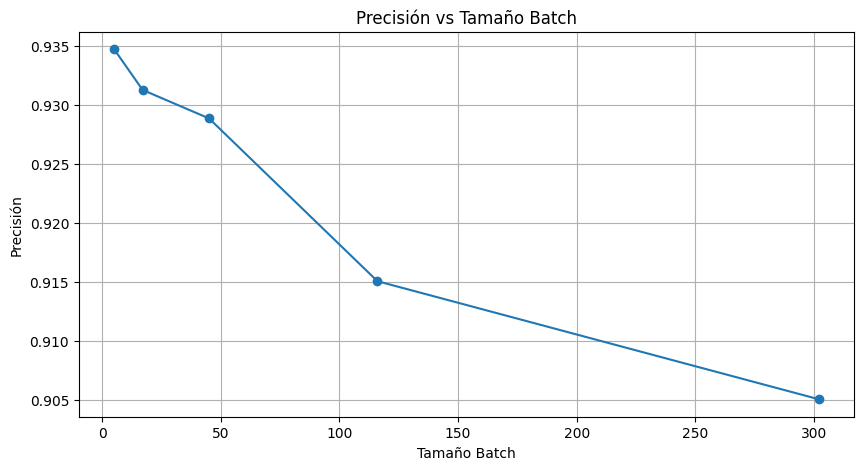

In [94]:
# Crear el gráfico de Precisión vs Tamaño Batch
plt.figure(figsize=(10, 5))
plt.plot(tam_batch, accuracies_4, marker='o')
plt.title('Precisión vs Tamaño Batch')
plt.xlabel('Tamaño Batch')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

###### Numero de batch con mejor accuracy: 5

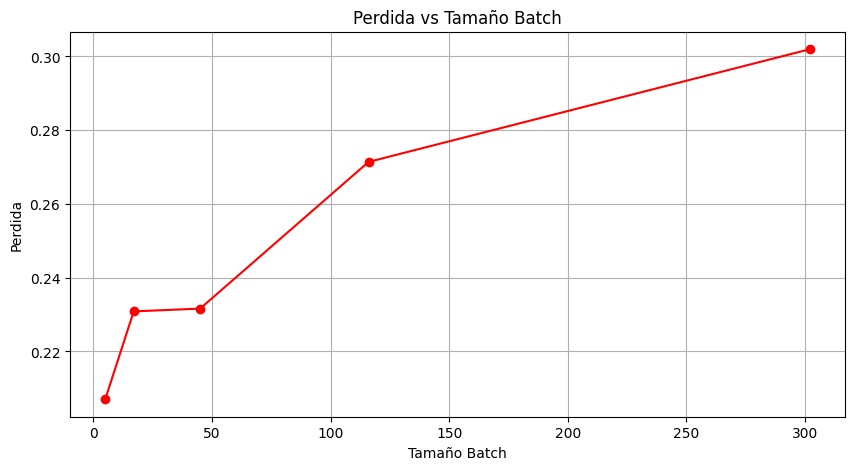

In [95]:
# Crear el gráfico de Perdida vs Tamaño Batch
plt.figure(figsize=(10, 5))
plt.plot(tam_batch, losses_4, marker='o',color='r')
plt.title('Perdida vs Tamaño Batch')
plt.xlabel('Tamaño Batch')
plt.ylabel('Perdida')
plt.grid(True)
plt.show()

###### Numero de batch con perdida mas baja: 5

Eleccion modelo optimo, segun lo obtenido en la experimentación

* Capas: 6
* Neuronas: 129
* Epocas: 80
* Batch: 5

In [104]:
# Inicializar con la clase sequiential
model= kr.models.Sequential()

# Capa densa con 129 neuronas, funcion activacion ReLu y filas de datos con 16 variables
model.add(kr.layers.Dense(129,input_dim=16,activation='relu'))

# Capas ocultas
model.add(kr.layers.Dense(8,activation='relu'))
model.add(kr.layers.Dense(8,activation='relu'))
model.add(kr.layers.Dense(8,activation='relu'))
model.add(kr.layers.Dense(8,activation='relu'))
model.add(kr.layers.Dense(8,activation='relu'))
model.add(kr.layers.Dense(8,activation='relu'))

# Capa salida, con 2 neuronas por las clases/categorias del dataset
model.add(kr.layers.Dense(2,activation='softmax'))

# Compilacion del modelo
# Funcion perdida, optimizador y metrica de evaluacion
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# Ajuste del modelo
# Entrenamiento del modelo

model.fit(X_train,y_train, epochs=80,batch_size=5)


Epoch 1/80
4633/4633 [==============================] - 10s 2ms/step - loss: 0.3711 - accuracy: 0.8538
Epoch 2/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2932 - accuracy: 0.8901
Epoch 3/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2651 - accuracy: 0.9012
Epoch 4/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2455 - accuracy: 0.9106
Epoch 5/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2318 - accuracy: 0.9155
Epoch 6/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2289 - accuracy: 0.9163
Epoch 7/80
4633/4633 [==============================] - 10s 2ms/step - loss: 0.2215 - accuracy: 0.9228
Epoch 8/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2141 - accuracy: 0.9256
Epoch 9/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2090 - accuracy: 0.9258
Epoch 10/80
4633/4633 [==============================] - 9s 2ms/step - loss: 0.2

In [105]:
# Imprimimos la precision del modelo

loss, accuracy = model.evaluate(X_test,y_test)
print(f'{loss=},{accuracy=}')

181/181 [==============================] - 1s 1ms/step - loss: 0.1539 - accuracy: 0.9423
loss=0.1538601666688919,accuracy=0.9423242807388306
